In [11]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from langchain_community.llms import Ollama
import warnings
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

warnings.filterwarnings("ignore", category=FutureWarning)

# Data pre processing


Read workbook, extract data from each sheet (Comapny), then combine result in one global dataframe


### Extract data from sheet number :


Sheet Lists :
'Russia - Sberbank Rossii PAO (S'

'Turkey - Koc Holding AS (KCHOL)'

'Egypt - Medinet Nasr Housing (M'

'Brazil - Minerva SABrazil (BEEF'

'Argentina - Pampa Energia SA (P'

'Colombia - Cementos Argos SA (C'

'South Africa - Impala Platinum '

'South Korea - Dongkuk Steel Mil'


In [12]:
def get_company_data(sheet):
    """
    Read data from Excel file and return sheet name and DataFrame.
    Args:
        sheet: Sheet name or number to read
    Returns:
        tuple: (sheet_name, DataFrame)
    """
    # Specify the path to your Excel file
    file_path = "data/2020Q1Q2Q3Q4-2021Q1.xlsx"

    try:
        # Read the Excel file
        if isinstance(sheet, int):
            # If sheet is a number, read all sheets and get sheet name from excel
            xl = pd.ExcelFile(file_path)
            sheet_name = xl.sheet_names[sheet]
            df = pd.read_excel(file_path, sheet_name=sheet)
        else:
            # If sheet is a name, use it directly
            sheet_name = sheet
            df = pd.read_excel(file_path, sheet_name=sheet)

        # Add company name as the first column
        df["Company"] = sheet_name
        # Remove the last row if it's a total or empty
        df = df.iloc[:-1]
        # Reorder columns to have Company as the first column
        df = df[["Company"] + [col for col in df.columns if col != "Company"]]

        return sheet_name, df

    except Exception as e:
        print(f"Error reading Excel file: {str(e)}")
        return None, None

In [13]:
# Get company and dataframe from sheet number
company, df = get_company_data(0)
df

,Company,Date,Price,Open,High,Low,Vol.,Change %
0,Russia - Sberbank Rossii PAO (S,2021-03-31 00:00:00,291.02,294,294.42,290.26,47.00M,-0.0076
1,Russia - Sberbank Rossii PAO (S,2021-03-30 00:00:00,293.25,294.86,295.72,291.5,38.81M,-0.0002
2,Russia - Sberbank Rossii PAO (S,2021-03-29 00:00:00,293.3,289.72,294.09,289.26,43.68M,0.0071
3,Russia - Sberbank Rossii PAO (S,2021-03-26 00:00:00,291.22,288.63,292.75,288.32,56.07M,0.0159
4,Russia - Sberbank Rossii PAO (S,2021-03-25 00:00:00,286.66,286.5,287.03,283.85,35.22M,0.0030
...,...,...,...,...,...,...,...,...
306,Russia - Sberbank Rossii PAO (S,2020-01-10 00:00:00,258.19,257.86,259.25,256.88,18.85M,0.0008
307,Russia - Sberbank Rossii PAO (S,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045
308,Russia - Sberbank Rossii PAO (S,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207
309,Russia - Sberbank Rossii PAO (S,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043


### Convert columns to relevant types


In [14]:
def preprocess_data(df, verbose=True):
    """
    Preprocess stock market data by converting columns to appropriate data types.

    Args:
        df (pd.DataFrame): Input DataFrame containing stock market data
        verbose (bool): If True, print information about the processed data

    Returns:
        pd.DataFrame: Preprocessed DataFrame with converted data types
    """
    # Create a copy of the DataFrame to avoid modifying the original
    processed_df = df.copy()

    # Convert Date column to datetime
    processed_df["Date"] = pd.to_datetime(processed_df["Date"], errors="coerce")

    # Convert numeric columns
    numeric_columns = ["Price", "Open", "High", "Low", "Change %"]
    for col in numeric_columns:
        processed_df[col] = pd.to_numeric(processed_df[col], errors="coerce")

    # Handle Volume column
    def convert_volume(vol):
        if isinstance(vol, str):
            if "K" in vol:
                return float(vol.replace("K", "")) * 1000
            elif "M" in vol:
                return float(vol.replace("M", "")) * 1000000
        return pd.to_numeric(vol, errors="coerce")

    processed_df["Vol."] = processed_df["Vol."].apply(convert_volume)

    # Convert Change % to actual percentage
    processed_df["Change %"] = processed_df["Change %"]

    if verbose:
        print("Data types after preprocessing:")
        print(processed_df.dtypes)
        print("\nFirst few rows of processed data:")
        print(processed_df.head())

    return processed_df

In [15]:
df = preprocess_data(df, verbose=False)
df

,Company,Date,Price,Open,High,Low,Vol.,Change %
0,Russia - Sberbank Rossii PAO (S,2021-03-31,291.02,294.00,294.42,290.26,47000000.0,-0.0076
1,Russia - Sberbank Rossii PAO (S,2021-03-30,293.25,294.86,295.72,291.50,38810000.0,-0.0002
2,Russia - Sberbank Rossii PAO (S,2021-03-29,293.30,289.72,294.09,289.26,43680000.0,0.0071
3,Russia - Sberbank Rossii PAO (S,2021-03-26,291.22,288.63,292.75,288.32,56070000.0,0.0159
4,Russia - Sberbank Rossii PAO (S,2021-03-25,286.66,286.50,287.03,283.85,35220000.0,0.0030
...,...,...,...,...,...,...,...,...
306,Russia - Sberbank Rossii PAO (S,2020-01-10,258.19,257.86,259.25,256.88,18850000.0,0.0008
307,Russia - Sberbank Rossii PAO (S,2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.0045
308,Russia - Sberbank Rossii PAO (S,2020-01-08,259.15,253.57,259.15,253.03,40820000.0,0.0207
309,Russia - Sberbank Rossii PAO (S,2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.0043


### Aggregate by Week, Month or Quarter


In [16]:
def aggregate_stock_data(df, frequency="W"):
    """
    Aggregate stock data by a specified frequency (weekly, monthly, quarterly).
    Args:
        df (pd.DataFrame): Input DataFrame containing stock market data.
        frequency (str): Resampling frequency. Options:
                         'W' for weekly,
                         'M' for monthly,
                         'Q' for quarterly.
    Returns:
        pd.DataFrame: Aggregated DataFrame.
    """
    # Ensure the 'Date' column is a datetime type
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    # Drop rows with invalid or missing dates
    df = df.dropna(subset=["Date"])

    # Set the 'Date' column as the index
    df = df.set_index("Date")

    # Resample the data based on the specified frequency
    aggregated_df = df.resample(frequency).agg(
        {
            "Price": "mean",  # Average price over the period
            "Open": "first",  # Opening price of the first day in the period
            "High": "max",  # Highest price in the period
            "Low": "min",  # Lowest price in the period
            "Vol.": "sum",  # Total volume over the period
            "Change %": "sum",  # Average percentage change over the period
        }
    )

    # Reset the index to bring 'Date' back as a column
    aggregated_df = aggregated_df.reset_index()

    return aggregated_df

In [17]:
df_w = aggregate_stock_data(df, "W")
df_m = aggregate_stock_data(df, "M")
df_q = aggregate_stock_data(df, "Q")

In [18]:
df_w

,Date,Price,Open,High,Low,Vol.,Change %
0,2020-01-05,255.000000,255.99,258.19,253.70,35850000.0,0.0010
1,2020-01-12,257.307500,254.75,261.76,251.40,120350000.0,0.0127
2,2020-01-19,259.554000,258.30,263.22,254.21,191510000.0,0.0170
3,2020-01-26,266.020000,263.20,270.80,261.80,180100000.0,0.0116
4,2020-02-02,256.494000,261.00,262.10,252.17,219330000.0,-0.0503
...,...,...,...,...,...,...,...
61,2021-03-07,276.588000,273.00,283.83,271.13,347350000.0,0.0272
62,2021-03-14,284.740000,278.80,288.00,277.56,226860000.0,0.0271
63,2021-03-21,286.628000,286.05,293.88,278.03,390400000.0,0.0031
64,2021-03-28,286.984000,285.00,292.75,282.11,271220000.0,0.0203


# EDA


## Basic Information


In [19]:
print("Basic Information:")
print(df.info())  # Data types and non-null counts
print("\nSummary Statistics:")
print(df.describe())  # Summary statistics for numeric colu

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Company   311 non-null    object        
 1   Date      311 non-null    datetime64[ns]
 2   Price     311 non-null    float64       
 3   Open      311 non-null    float64       
 4   High      311 non-null    float64       
 5   Low       311 non-null    float64       
 6   Vol.      311 non-null    float64       
 7   Change %  311 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 19.6+ KB
None

Summary Statistics:
                                Date       Price        Open        High  \
count                            311  311.000000  311.000000  311.000000   
mean   2020-08-17 15:21:24.887459840  234.524019  234.417846  237.314759   
min              2020-01-03 00:00:00  174.270000  175.000000  182.200000   
25%            

In [20]:
# 2. Check for Missing Values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Company     0
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


### Describe by Company


In [21]:
# 3. Grouped Summary Statistics by Company
print("\nSummary Price by Company:")
df["Price"].describe()


Summary Price by Company:


count    311.000000
mean     234.524019
std       32.079847
min      174.270000
25%      207.700000
50%      229.140000
75%      264.380000
max      293.300000
Name: Price, dtype: float64

In [22]:
# 3. Grouped Summary Statistics by Company
print("\nSummary Change by Company:")
df["Change %"].describe()


Summary Change by Company:


count    311.000000
mean       0.000668
std        0.021931
min       -0.095700
25%       -0.010100
50%        0.000400
75%        0.012950
max        0.129000
Name: Change %, dtype: float64

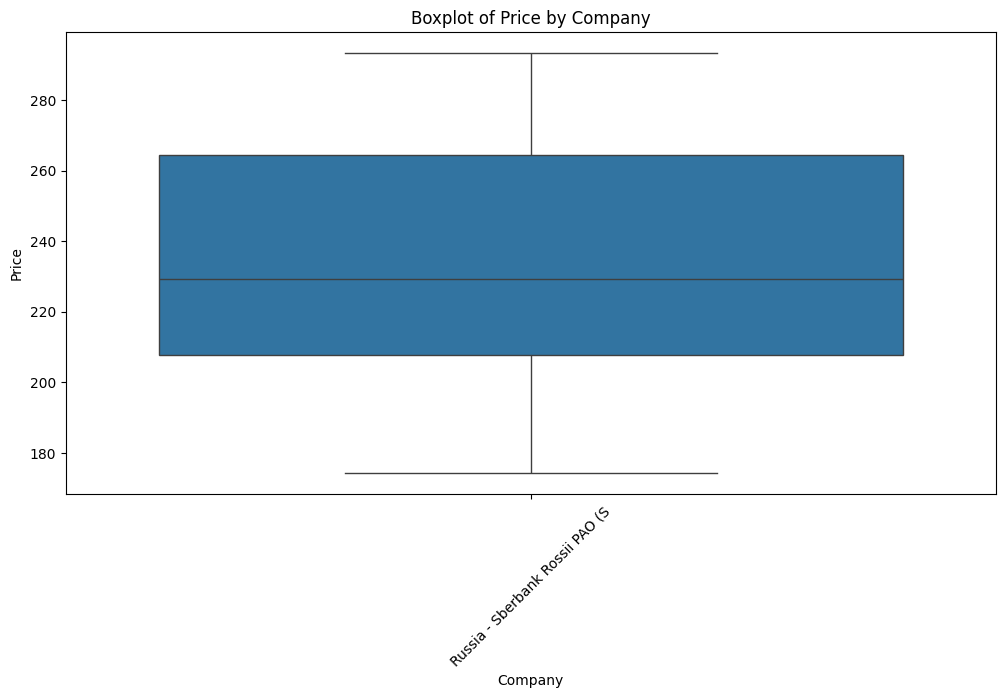

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Price by Company
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Company", y="Price")
plt.title("Boxplot of Price by Company")
plt.xticks(rotation=45)
plt.show()

In [24]:
def generate_bollinger_bands(df, period="D"):
    """
    Generate Bollinger Bands and other technical indicators from stock data.
    Returns a simplified DataFrame with only essential price and Bollinger Bands data.

    Args:
        df (pd.DataFrame): DataFrame containing stock data
        period (str): Time period for analysis ('D' for daily, 'W' for weekly,
                     'M' for monthly, 'Q' for quarterly)

    Returns:
        pd.DataFrame: DataFrame with Date, Price, Open, High, Low, MA20, and Bollinger Bands
    """
    # Make a copy and ensure Date is datetime
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])

    # Resample data based on period
    if period != "D":
        df_resampled = (
            df.set_index("Date")
            .resample(period)
            .agg({"Price": "mean", "Open": "first", "High": "max", "Low": "min"})
            .reset_index()
        )
    else:
        df_resampled = df

    # Calculate MA20 and Bollinger Bands
    df_resampled["MA20"] = df_resampled["Price"].rolling(window=20).mean()
    df_resampled["Upper_Band"] = df_resampled["MA20"] + (
        df_resampled["Price"].rolling(window=20).std() * 2
    )
    df_resampled["Lower_Band"] = df_resampled["MA20"] - (
        df_resampled["Price"].rolling(window=20).std() * 2
    )

    # Select only required columns
    bb_df = df_resampled[
        ["Date", "Price", "Open", "High", "Low", "MA20", "Upper_Band", "Lower_Band"]
    ]

    # Set Date as index and sort in descending order
    bb_df = bb_df.set_index("Date").sort_index(ascending=True)

    return bb_df

In [25]:
df_bb = generate_bollinger_bands(df)
df_bb

,Price,Open,High,Low,MA20,Upper_Band,Lower_Band
Date,,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,259.7285,268.766453,250.690547
2020-01-06,253.90,254.75,254.84,251.40,259.6780,268.837666,250.518334
2020-01-08,259.15,253.57,259.15,253.03,259.7530,268.736330,250.769670
2020-01-09,257.99,259.40,261.76,257.01,259.5555,268.765473,250.345527
2020-01-10,258.19,257.86,259.25,256.88,259.2615,269.039758,249.483242
...,...,...,...,...,...,...,...
2021-03-25,286.66,286.50,287.03,283.85,NaN,NaN,NaN
2021-03-26,291.22,288.63,292.75,288.32,NaN,NaN,NaN
2021-03-29,293.30,289.72,294.09,289.26,NaN,NaN,NaN


In [26]:
def print_technical_statistics(df_resampled, company_name, period="D"):
    """
    Print technical analysis statistics and metrics.

    Args:
        df_resampled (pd.DataFrame): DataFrame with technical analysis data
        company_name (str): Name of the company
        period (str): Time period used for analysis ('D', 'W', 'M', 'Q')
    """
    # Period labels for output
    period_labels = {"D": "Daily", "W": "Weekly", "M": "Monthly", "Q": "Quarterly"}

    # Print summary statistics
    print(f"\nSummary Statistics for {company_name} ({period_labels[period]}):")
    print("-" * 50)
    summary_stats = df_resampled[["Price", "High", "Low"]].describe()
    print(summary_stats)

    # Calculate additional metrics
    latest_price = df_resampled["Price"].iloc[-1]
    price_change = (
        (latest_price - df_resampled["Price"].iloc[0])
        / df_resampled["Price"].iloc[0]
        * 100
    )
    avg_price = df_resampled["Price"].mean()
    price_std = df_resampled["Price"].std()

    # Calculate Bollinger Bands statistics
    bb_width = (
        (df_resampled["Upper_Band"] - df_resampled["Lower_Band"]) / df_resampled["MA20"]
    ) * 100
    bb_width = bb_width.dropna()

    print(f"\nBollinger Bands Analysis:")
    print("-" * 50)
    print(f"Average Band Width: {bb_width.mean():.2f}%")
    print(f"Maximum Band Width: {bb_width.max():.2f}%")
    print(f"Minimum Band Width: {bb_width.min():.2f}%")

    # Calculate price position relative to bands
    price_position = (
        (df_resampled["Price"] - df_resampled["Lower_Band"])
        / (df_resampled["Upper_Band"] - df_resampled["Lower_Band"])
        * 100
    ).dropna()

    print(f"\nPrice Position Analysis:")
    print("-" * 50)
    print(
        f"Current Position: {price_position.iloc[-1]:.2f}% (0%=Lower Band, 100%=Upper Band)"
    )
    print(f"Average Position: {price_position.mean():.2f}%")

    print(f"\nPrice Statistics:")
    print("-" * 50)
    print(f"Latest Price: {latest_price:.2f}")
    print(f"Total Price Change: {price_change:.2f}%")
    print(f"Average Price: {avg_price:.2f}")
    print(f"Price Standard Deviation: {price_std:.2f}")

    # Calculate moving average crossovers
    ma_crossovers = (
        (df_resampled["Price"] > df_resampled["MA20"])
        & (df_resampled["Price"].shift(1) <= df_resampled["MA20"].shift(1))
        | (df_resampled["Price"] < df_resampled["MA20"])
        & (df_resampled["Price"].shift(1) >= df_resampled["MA20"].shift(1))
    ).sum()

    print(f"\nTechnical Signals:")
    print("-" * 50)
    print(f"Number of MA20 Crossovers: {ma_crossovers}")
    print(
        f"Current Price vs MA20: {'Above' if latest_price > df_resampled['MA20'].iloc[-1] else 'Below'}"
    )

    # Band touches/breaks
    upper_breaks = (df_resampled["Price"] > df_resampled["Upper_Band"]).sum()
    lower_breaks = (df_resampled["Price"] < df_resampled["Lower_Band"]).sum()

    print(f"Upper Band Breaks: {upper_breaks}")
    print(f"Lower Band Breaks: {lower_breaks}")

    # Current trend
    last_20_trend = (
        "Upward"
        if df_resampled["Price"].tail(20).is_monotonic_increasing
        else "Downward"
        if df_resampled["Price"].tail(20).is_monotonic_decreasing
        else "Sideways"
    )

    print(f"Recent Trend (Last 20 periods): {last_20_trend}")

In [27]:
def plot_only_bollinger_bands(df_resampled, company_name, period="D"):
    """
    Plot only Bollinger Bands chart.

    Args:
        df_resampled (pd.DataFrame): DataFrame with Bollinger Bands data
        company_name (str): Name of the company
        period (str): Time period used for analysis
    """
    # Create figure
    plt.figure(figsize=(15, 8))

    # Plot Price and Bollinger Bands
    plt.plot(df_resampled.index, df_resampled["Price"], label="Price", color="blue")
    plt.plot(
        df_resampled.index, df_resampled["MA20"], label="20-period MA", color="red"
    )
    plt.plot(
        df_resampled.index,
        df_resampled["Upper_Band"],
        label="Upper BB",
        color="gray",
        linestyle="--",
    )
    plt.plot(
        df_resampled.index,
        df_resampled["Lower_Band"],
        label="Lower BB",
        color="gray",
        linestyle="--",
    )

    # Add shaded area between bands
    plt.fill_between(
        df_resampled.index,
        df_resampled["Upper_Band"],
        df_resampled["Lower_Band"],
        alpha=0.1,
        color="gray",
    )

    # Customize the plot
    plt.title(f"{company_name} Bollinger Bands Analysis ({period})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_technical_analysis(df_resampled, company_name, period="D"):
    """
    Plot comprehensive technical analysis charts including volume, price changes, and distributions.

    Args:
        df_resampled (pd.DataFrame): DataFrame with Bollinger Bands data
        company_name (str): Name of the company
        period (str): Time period used for analysis
    """
    # Create subplots
    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 2, figure=fig)

    # 2. Volume Analysis
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.bar(df_resampled.index, df_resampled["Vol."], color="blue", alpha=0.6)
    ax2.set_title(f"Volume Analysis ({period})")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Volume")
    ax2.grid(True)

    # 3. Period Change % Analysis
    ax3 = fig.add_subplot(gs[1, 1])
    colors = ["red" if x < 0 else "green" for x in df_resampled["Change %"]]
    ax3.bar(df_resampled.index, df_resampled["Change %"], color=colors, alpha=0.6)
    ax3.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    ax3.set_title(f"Price Change % by {period}")
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Change %")
    ax3.grid(True)

    # 4. Price Range (High-Low)
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.fill_between(
        df_resampled.index,
        df_resampled["High"],
        df_resampled["Low"],
        alpha=0.3,
        color="gray",
    )
    ax4.plot(df_resampled.index, df_resampled["Price"], color="blue", label="Price")
    ax4.set_title(f"Price Range Analysis ({period})")
    ax4.set_xlabel("Date")
    ax4.set_ylabel("Price")
    ax4.grid(True)
    ax4.legend()

    # 5. Box Plot
    ax5 = fig.add_subplot(gs[2, 1])
    box_data = pd.DataFrame(
        {
            "Price": df_resampled["Price"],
            "Open": df_resampled["Open"],
            "High": df_resampled["High"],
            "Low": df_resampled["Low"],
        }
    )
    sns.boxplot(data=box_data, ax=ax5)
    ax5.set_title(f"Price Distribution Box Plot ({period})")
    ax5.set_ylabel("Price")
    sns.stripplot(data=box_data, color="red", size=4, alpha=0.3, ax=ax5)

    plt.tight_layout()
    plt.show()

    # Print statistics and metrics
    print_technical_statistics(df_resampled, company_name, period)

In [28]:
company

'Russia - Sberbank Rossii PAO (S'

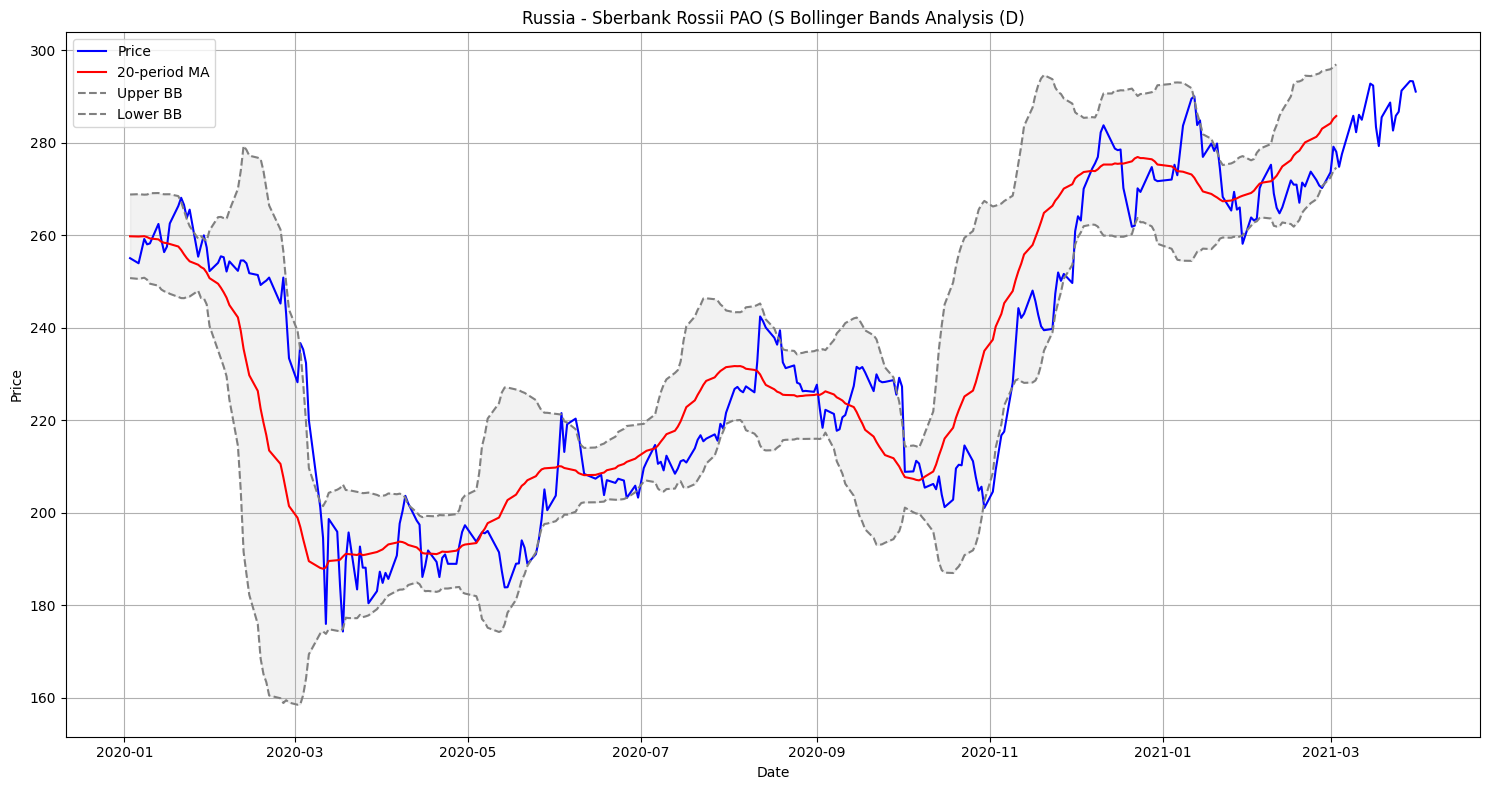

In [29]:
# Generate Bollinger Bands data
df_bb = generate_bollinger_bands(df)

# Plot only Bollinger Bands
plot_only_bollinger_bands(df_bb, company, period="D")

# Or plot full technical analysis
# plot_technical_analysis(df, company, period="D")

## Apply Bollinger bands strategy


In [45]:
def apply_bollinger_bands_strategy(df):
    """
    Apply Bollinger Bands trading strategy to determine buy, sell, or hold signals.

    Strategy rules:
    - Buy when price crosses below lower band
    - Sell when price crosses above upper band
    - Hold when price is between bands

    Args:
        df (pd.DataFrame): DataFrame with Bollinger Bands data

    Returns:
        pd.DataFrame: DataFrame with added signals and positions
    """
    # Make a copy of the dataframe
    df = df.copy()

    # Initialize signals column
    df["Signal"] = "HOLD"

    # Generate signals
    # Buy signals: Price crosses below lower band
    df.loc[df["Price"] < df["Lower_Band"], "Signal"] = "BUY"

    # Sell signals: Price crosses above upper band
    df.loc[df["Price"] > df["Upper_Band"], "Signal"] = "SELL"

    # Calculate additional indicators for signal strength
    # Percentage B: Position of price within the bands (0-100%)
    df["%B"] = (df["Price"] - df["Lower_Band"]) / (df["Upper_Band"] - df["Lower_Band"])

    # Band Width: Measure of volatility
    df["Band_Width"] = ((df["Upper_Band"] - df["Lower_Band"]) / df["MA20"]) * 100

    # Add signal strength indicators
    df["Signal_Strength"] = "Normal"

    # Strong buy signals (price well below lower band)
    df.loc[df["%B"] < -0.05, "Signal_Strength"] = "Strong"

    # Strong sell signals (price well above upper band)
    df.loc[df["%B"] > 1.05, "Signal_Strength"] = "Strong"

    # Add trend direction
    df["Trend"] = "Sideways"
    df.loc[df["Price"] > df["MA20"], "Trend"] = "Uptrend"
    df.loc[df["Price"] < df["MA20"], "Trend"] = "Downtrend"

    # Combine signal and strength
    df["Strategy"] = df["Signal"] + " (" + df["Signal_Strength"] + ")"

    # Calculate potential profit/loss zones
    df["Risk_Level"] = "Medium"
    df.loc[
        df["Band_Width"] > df["Band_Width"].mean() + df["Band_Width"].std(),
        "Risk_Level",
    ] = "High"
    df.loc[
        df["Band_Width"] < df["Band_Width"].mean() - df["Band_Width"].std(),
        "Risk_Level",
    ] = "Low"

    return df


def print_strategy_summary(df):
    """
    Print summary of the Bollinger Bands trading strategy results.

    Args:
        df (pd.DataFrame): DataFrame with strategy signals
    """
    print("Bollinger Bands Strategy Summary")
    print("-" * 50)

    # Count signals
    signal_counts = df["Signal"].value_counts()
    print("\nSignal Distribution:")
    for signal, count in signal_counts.items():
        print(f"{signal}: {count} ({count / len(df) * 100:.1f}%)")

    # Risk level distribution
    print("\nRisk Level Distribution:")
    risk_counts = df["Risk_Level"].value_counts()
    for risk, count in risk_counts.items():
        print(f"{risk}: {count} ({count / len(df) * 100:.1f}%)")

    # Trend analysis
    print("\nTrend Distribution:")
    trend_counts = df["Trend"].value_counts()
    for trend, count in trend_counts.items():
        print(f"{trend}: {count} ({count / len(df) * 100:.1f}%)")

    # Current position
    latest = df.iloc[-1]
    print(f"\nCurrent Position (as of {df.index[-1].strftime('%Y-%m-%d')}):")
    print(f"Signal: {latest['Strategy']}")
    print(f"Price: {latest['Price']:.2f}")
    print(f"Position in Band (%B): {latest['%B'] * 100:.1f}%")
    print(f"Band Width: {latest['Band_Width']:.2f}%")
    print(f"Trend: {latest['Trend']}")
    print(f"Risk Level: {latest['Risk_Level']}")


# Apply the strategy to your Bollinger Bands DataFrame
df_strategy = apply_bollinger_bands_strategy(df_bb)

# Print the strategy summary
print_strategy_summary(df_strategy)

# Display the last few days of signals
print("\nRecent Trading Signals:")
print("-" * 50)
print(
    df_strategy[
        ["Price", "MA20", "Upper_Band", "Lower_Band", "Strategy", "Trend", "Risk_Level"]
    ].tail()
)

Bollinger Bands Strategy Summary
--------------------------------------------------

Signal Distribution:
HOLD: 277 (89.1%)
SELL: 20 (6.4%)
BUY: 14 (4.5%)

Risk Level Distribution:
Medium: 271 (87.1%)
High: 37 (11.9%)
Low: 3 (1.0%)

Trend Distribution:
Downtrend: 168 (54.0%)
Uptrend: 124 (39.9%)
Sideways: 19 (6.1%)

Current Position (as of 2021-03-31):
Signal: HOLD (Normal)
Price: 291.02
Position in Band (%B): nan%
Band Width: nan%
Trend: Sideways
Risk Level: Medium

Recent Trading Signals:
--------------------------------------------------
             Price  MA20  Upper_Band  Lower_Band       Strategy     Trend  \
Date                                                                        
2021-03-25  286.66   NaN         NaN         NaN  HOLD (Normal)  Sideways   
2021-03-26  291.22   NaN         NaN         NaN  HOLD (Normal)  Sideways   
2021-03-29  293.30   NaN         NaN         NaN  HOLD (Normal)  Sideways   
2021-03-30  293.25   NaN         NaN         NaN  HOLD (Normal)  Sid

Bollinger Bands Strategy Summary
--------------------------------------------------

Signal Distribution:
HOLD: 277 (89.1%)
SELL: 20 (6.4%)
BUY: 14 (4.5%)

Risk Level Distribution:
Medium: 271 (87.1%)
High: 37 (11.9%)
Low: 3 (1.0%)

Trend Distribution:
Downtrend: 168 (54.0%)
Uptrend: 124 (39.9%)
Sideways: 19 (6.1%)

Current Position (as of 2021-03-31):
Signal: HOLD (Normal)
Price: 291.02
Position in Band (%B): nan%
Band Width: nan%
Trend: Sideways
Risk Level: Medium


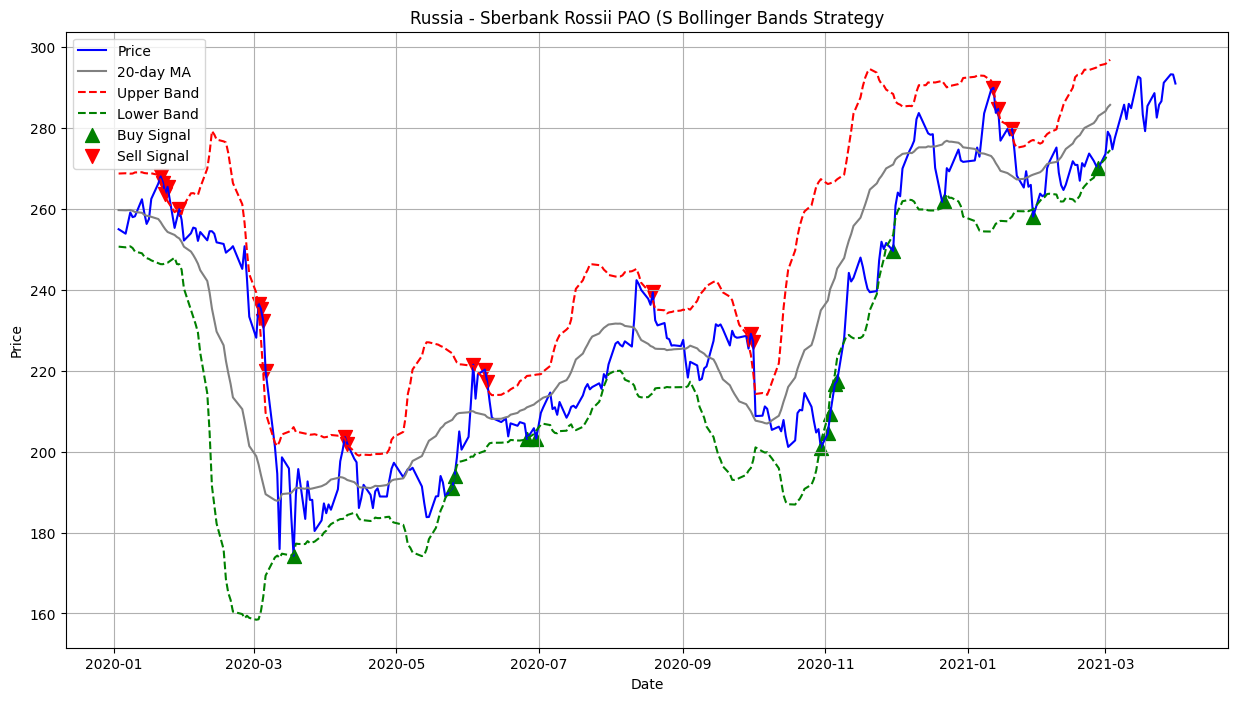

In [47]:
# Generate Bollinger Bands data if you haven't already
df_bb = generate_bollinger_bands(df)

# Apply the strategy
df_strategy = apply_bollinger_bands_strategy(df_bb)

# Print strategy summary
print_strategy_summary(df_strategy)


# Plot the Bollinger Bands with signals
def plot_bollinger_bands_with_signals(df_strategy, company_name):
    plt.figure(figsize=(15, 8))

    # Plot price and bands
    plt.plot(df_strategy.index, df_strategy["Price"], label="Price", color="blue")
    plt.plot(df_strategy.index, df_strategy["MA20"], label="20-day MA", color="gray")
    plt.plot(
        df_strategy.index,
        df_strategy["Upper_Band"],
        label="Upper Band",
        color="red",
        linestyle="--",
    )
    plt.plot(
        df_strategy.index,
        df_strategy["Lower_Band"],
        label="Lower Band",
        color="green",
        linestyle="--",
    )

    # Plot buy signals
    buy_signals = df_strategy[df_strategy["Signal"] == "BUY"]
    plt.scatter(
        buy_signals.index,
        buy_signals["Price"],
        marker="^",
        color="green",
        s=100,
        label="Buy Signal",
    )

    # Plot sell signals
    sell_signals = df_strategy[df_strategy["Signal"] == "SELL"]
    plt.scatter(
        sell_signals.index,
        sell_signals["Price"],
        marker="v",
        color="red",
        s=100,
        label="Sell Signal",
    )

    plt.title(f"{company_name} Bollinger Bands Strategy")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot the strategy
plot_bollinger_bands_with_signals(df_strategy, company)

## Backtest



Backtest Results:
--------------------------------------------------
Initial Capital: $10,000.00
Final Portfolio Value: $25,852.46
Total Return: 158.52%
Buy & Hold Return: 14.13%

Total Trades: 9
Buy Trades: 5
Sell Trades: 4


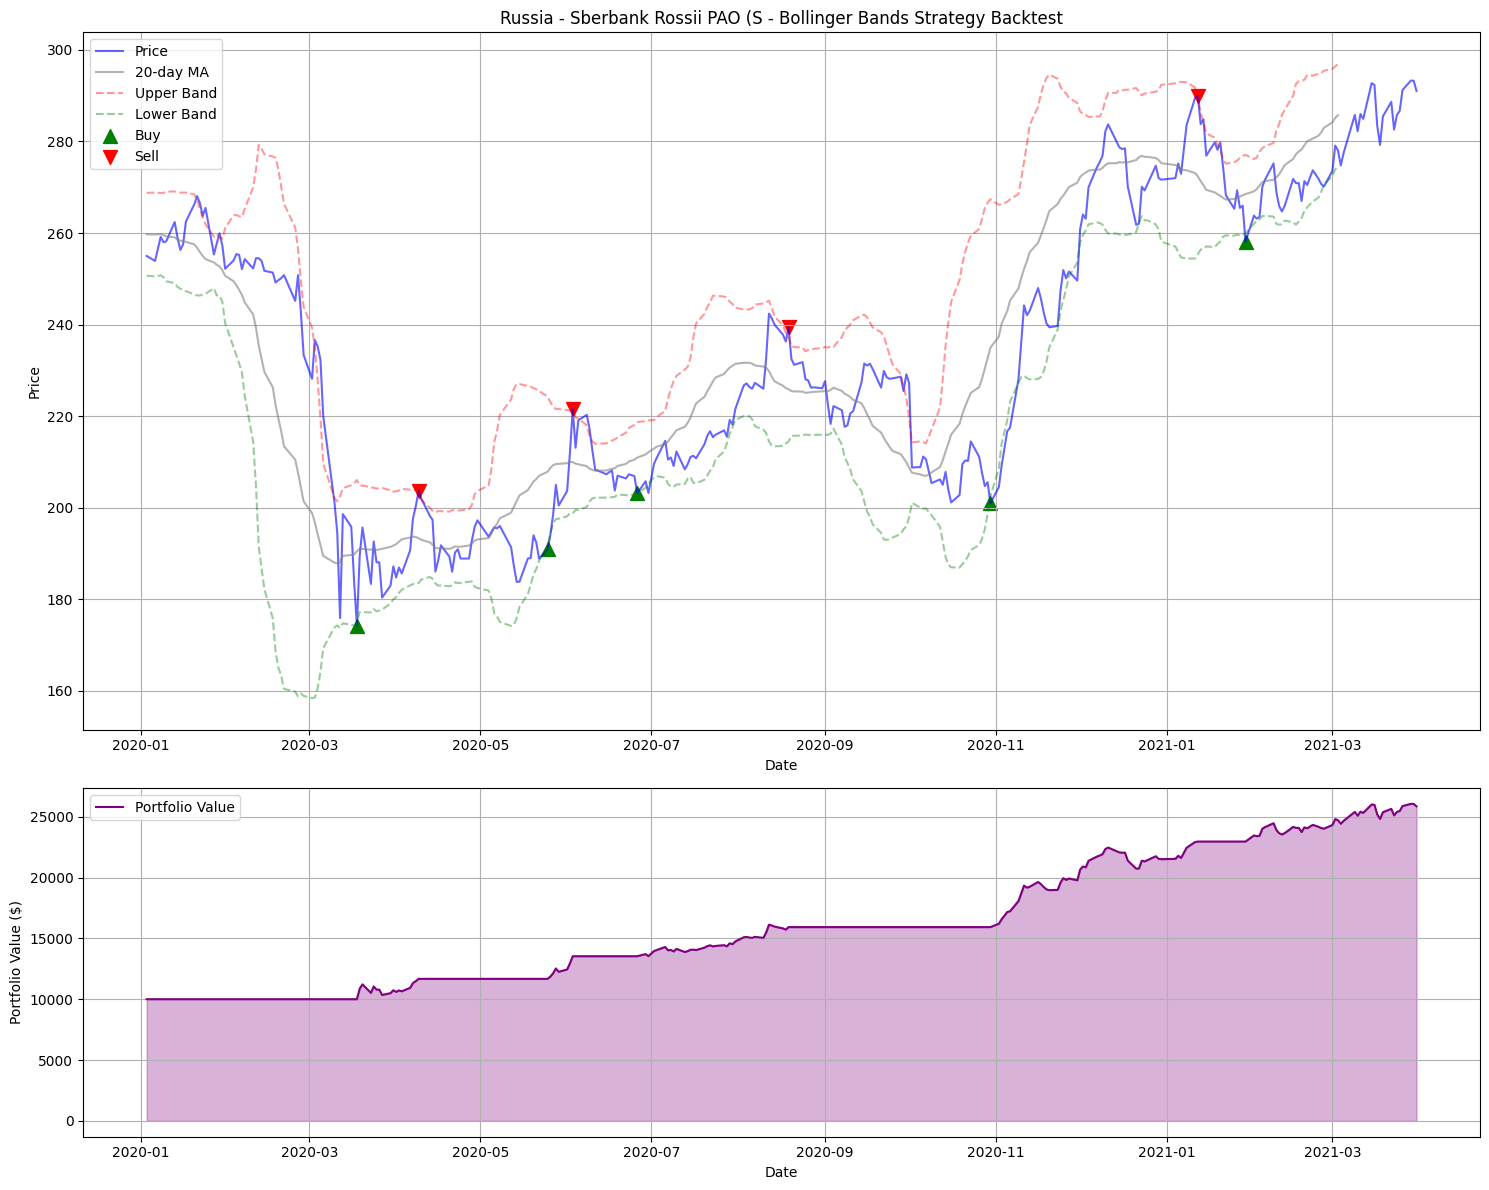

In [48]:
def backtest_bollinger_strategy(df, initial_capital=10000):
    """
    Backtest Bollinger Bands trading strategy with initial capital.
    Only executes trades in buy-sell alternating pattern.

    Args:
        df (pd.DataFrame): DataFrame with Bollinger Bands data
        initial_capital (float): Initial investment amount

    Returns:
        pd.DataFrame: DataFrame with trading signals and portfolio value
    """
    # Make a copy of the dataframe
    df = df.copy()

    # Initialize columns for signals and positions
    df["Signal"] = "HOLD"
    df["Position"] = 0
    df["Shares"] = 0
    df["Portfolio_Value"] = 0
    df["Cash"] = initial_capital

    # Generate basic signals
    df.loc[df["Price"] < df["Lower_Band"], "Signal"] = "BUY"
    df.loc[df["Price"] > df["Upper_Band"], "Signal"] = "SELL"

    # Initialize trading state
    looking_to_buy = True  # Start by looking for buy signals
    shares_held = 0
    cash = initial_capital

    # Process signals to ensure buy-sell alternation
    for i in range(len(df)):
        current_price = df.iloc[i]["Price"]
        current_signal = df.iloc[i]["Signal"]

        if looking_to_buy and current_signal == "BUY":
            # Calculate number of shares to buy with all available cash
            shares_to_buy = cash // current_price
            if shares_to_buy > 0:
                shares_held = shares_to_buy
                cash -= shares_to_buy * current_price
                df.iloc[i, df.columns.get_loc("Position")] = 1
                df.iloc[i, df.columns.get_loc("Shares")] = shares_held
                looking_to_buy = False

        elif not looking_to_buy and current_signal == "SELL":
            if shares_held > 0:
                # Sell all shares
                cash += shares_held * current_price
                df.iloc[i, df.columns.get_loc("Position")] = -1
                df.iloc[i, df.columns.get_loc("Shares")] = -shares_held
                shares_held = 0
                looking_to_buy = True

        # Update portfolio value
        df.iloc[i, df.columns.get_loc("Portfolio_Value")] = cash + (
            shares_held * current_price
        )
        df.iloc[i, df.columns.get_loc("Cash")] = cash

    # Calculate returns and metrics
    total_return = (
        (df["Portfolio_Value"].iloc[-1] - initial_capital) / initial_capital * 100
    )
    buy_hold_return = (
        (df["Price"].iloc[-1] - df["Price"].iloc[0]) / df["Price"].iloc[0] * 100
    )

    # Print backtest results
    print("\nBacktest Results:")
    print("-" * 50)
    print(f"Initial Capital: ${initial_capital:,.2f}")
    print(f"Final Portfolio Value: ${df['Portfolio_Value'].iloc[-1]:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Buy & Hold Return: {buy_hold_return:.2f}%")

    # Count trades
    trades = df[df["Position"] != 0]
    print(f"\nTotal Trades: {len(trades)}")
    print(f"Buy Trades: {len(trades[trades['Position'] > 0])}")
    print(f"Sell Trades: {len(trades[trades['Position'] < 0])}")

    return df


def plot_backtest_results(df, company_name):
    """
    Plot backtest results including portfolio value and trade signals.

    Args:
        df (pd.DataFrame): DataFrame with backtest results
        company_name (str): Name of the company
    """
    # Create figure with secondary y-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])

    # Plot price and bands
    ax1.plot(df.index, df["Price"], label="Price", color="blue", alpha=0.6)
    ax1.plot(df.index, df["MA20"], label="20-day MA", color="gray", alpha=0.6)
    ax1.plot(
        df.index,
        df["Upper_Band"],
        label="Upper Band",
        color="red",
        linestyle="--",
        alpha=0.4,
    )
    ax1.plot(
        df.index,
        df["Lower_Band"],
        label="Lower Band",
        color="green",
        linestyle="--",
        alpha=0.4,
    )

    # Plot buy signals
    buy_signals = df[df["Position"] > 0]
    ax1.scatter(
        buy_signals.index,
        buy_signals["Price"],
        marker="^",
        color="green",
        s=100,
        label="Buy",
    )

    # Plot sell signals
    sell_signals = df[df["Position"] < 0]
    ax1.scatter(
        sell_signals.index,
        sell_signals["Price"],
        marker="v",
        color="red",
        s=100,
        label="Sell",
    )

    ax1.set_title(f"{company_name} - Bollinger Bands Strategy Backtest")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price")
    ax1.grid(True)
    ax1.legend()

    # Plot portfolio value
    ax2.plot(df.index, df["Portfolio_Value"], label="Portfolio Value", color="purple")
    ax2.fill_between(df.index, df["Portfolio_Value"], alpha=0.3, color="purple")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Portfolio Value ($)")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


# Run backtest
df_backtest = backtest_bollinger_strategy(df_bb, initial_capital=10000)

# Plot results
plot_backtest_results(df_backtest, company)

# Staistical models


### ARIMA BAsics


An ARIMA model is by 3 ternms(p, d, q):

• p the of the AR term

• d is the number of differncing required to make the time series stationay

• q is the order of the MA term

As we see the parameters required by the model. any stationary time series can be modeled with ARIMA models.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Set 'Date' as the index and sort the data
df.set_index("Date", inplace=True)
df = df.sort_index()

# Ensure the data is in the correct order
df = df.sort_values("Date")


In [50]:
df

,Company,Price,Open,High,Low,Vol.,Change %
Date,,,,,,,
2020-01-03,Russia - Sberbank Rossii PAO (S,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-01-06,Russia - Sberbank Rossii PAO (S,253.90,254.75,254.84,251.40,22350000.0,-0.0043
2020-01-08,Russia - Sberbank Rossii PAO (S,259.15,253.57,259.15,253.03,40820000.0,0.0207
2020-01-09,Russia - Sberbank Rossii PAO (S,257.99,259.40,261.76,257.01,38330000.0,-0.0045
2020-01-10,Russia - Sberbank Rossii PAO (S,258.19,257.86,259.25,256.88,18850000.0,0.0008
...,...,...,...,...,...,...,...
2021-03-25,Russia - Sberbank Rossii PAO (S,286.66,286.50,287.03,283.85,35220000.0,0.0030
2021-03-26,Russia - Sberbank Rossii PAO (S,291.22,288.63,292.75,288.32,56070000.0,0.0159
2021-03-29,Russia - Sberbank Rossii PAO (S,293.30,289.72,294.09,289.26,43680000.0,0.0071


#### Split the data into training and testing sets


In [40]:
# Split data into training (2020) and testing (2021) sets
train = df[df.index.year == 2020].copy()
test = df[df.index.year == 2021].copy()

print("\nTraining data period:", train.index.min(), "to", train.index.max())
print("Test data period:", test.index.min(), "to", test.index.max())


Training data period: 2020-01-03 00:00:00 to 2020-12-30 00:00:00
Test data period: 2021-01-04 00:00:00 to 2021-03-31 00:00:00


#### Check if the time serie is stationary


In [ ]:
# Function to perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic: %f" % result[0])
    print("p-value: %f" % result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print("\t%s: %.3f" % (key, value))
    if result[1] > 0.05:
        print(
            "Failed to reject the null hypothesis. The series is likely non-stationary."
        )
    else:
        print("Reject the null hypothesis. The series is stationary.")


# Perform ADF test on the training data's 'Price' column
print("\nAugmented Dickey-Fuller test for training data:")
adf_test(train["Price"])


Augmented Dickey-Fuller test for training data:
ADF Statistic: -1.423324
p-value: 0.571045
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Failed to reject the null hypothesis. The series is likely non-stationary.


**Stationarity**

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple
times.
And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model.

**ADF test**

We'll use the **Augumented Dickey Fuller (ADF)** test to check if the price series is stationary.
The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can
reject the null hypothesis and infer that the time series is indeed stationary.
So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.


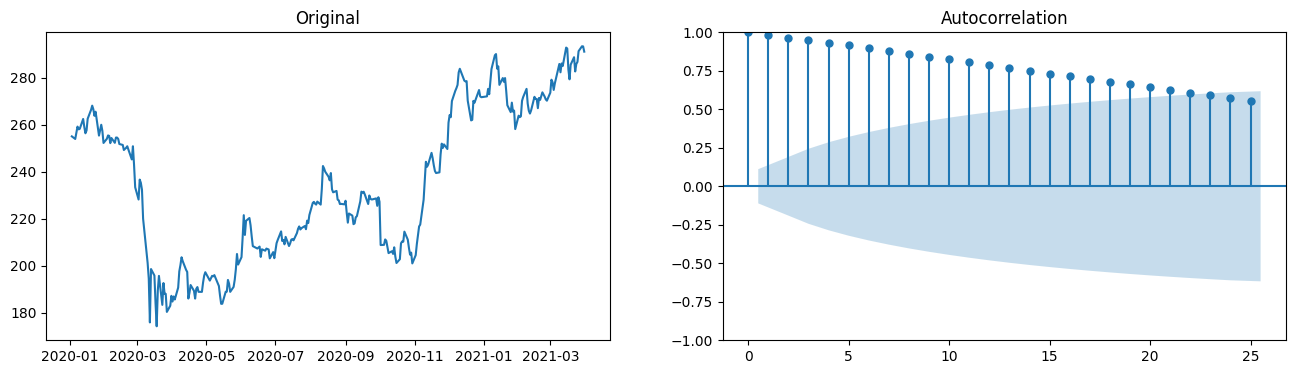

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(df.Price)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.Price, ax=ax2);

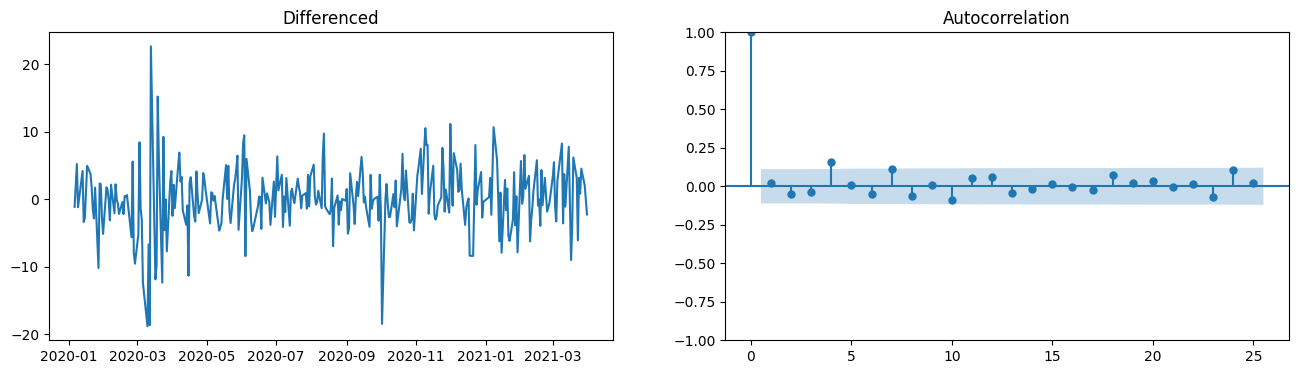

In [ ]:
diff = df.Price.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Differenced")
plot_acf(diff, ax=ax2);

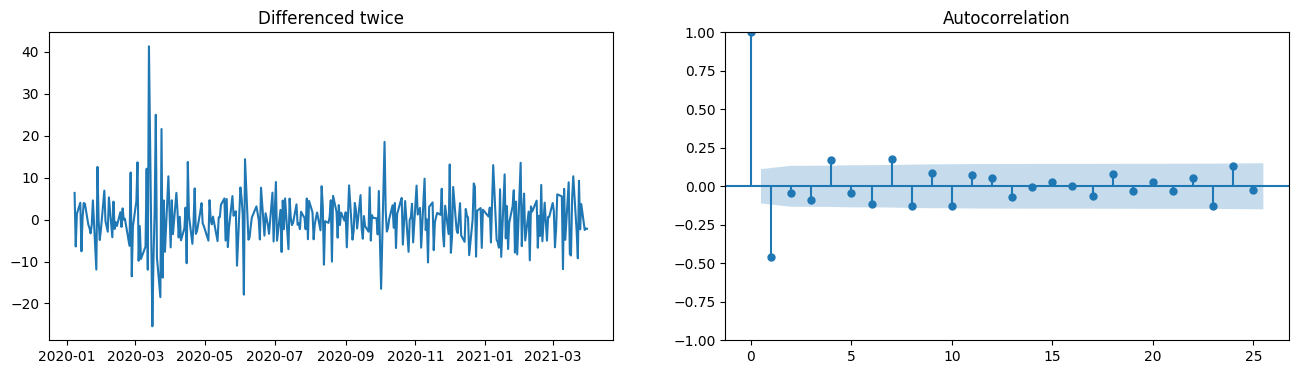

In [ ]:
diff = df.Price.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Differenced twice")
plot_acf(diff, ax=ax2);

Using pmdarima package to get the number of differencing


In [ ]:
# !pip install  pmdarima
from pmdarima.arima.utils import ndiffs

ndiffs(df.Price, test="adf")

1

**p**

p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors.

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags.


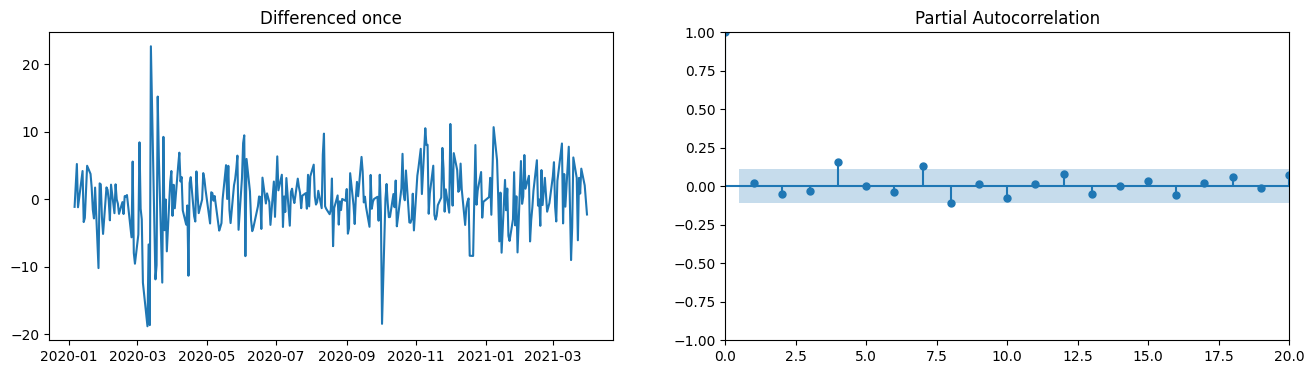

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

diff = df.Price.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Differenced once")
ax2.set_ylim(0, 1)
ax2.set_xlim(0, 20)
plot_pacf(diff, ax=ax2);

We can observe that the PACF lag 4 is significant as it's above the significance line


**q**

**q** is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.


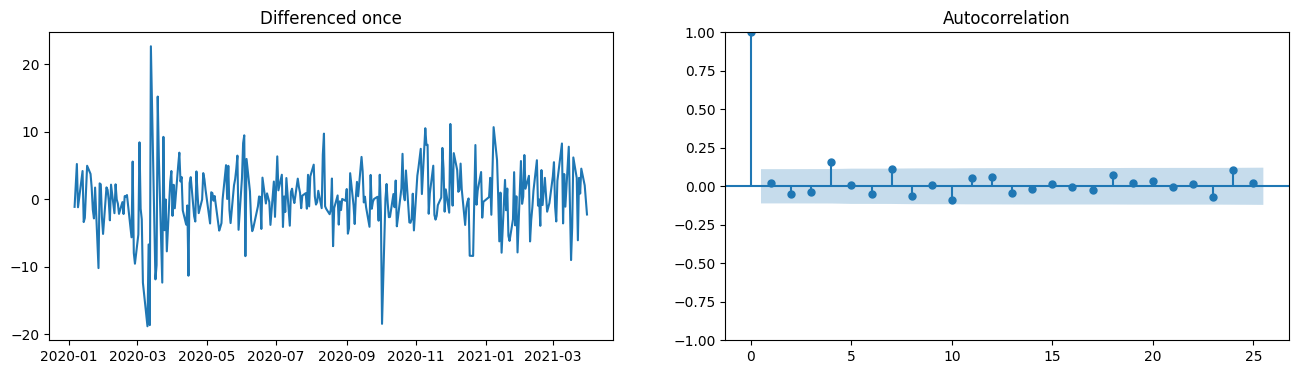

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

diff = df.Price.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Differenced once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

In [ ]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

%matplotlib inline

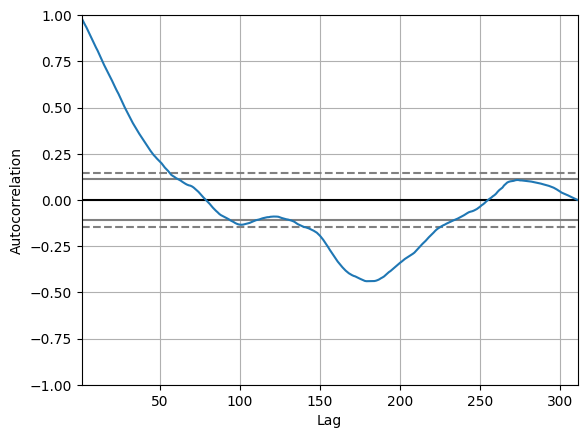

In [59]:
autocorrelation_plot(df.Price)
pyplot.show()

### ARIMA Training


In [ ]:
def evaluate_and_visualize_model(
    model, train, test, exog_test=None, model_name="ARIMA"
):
    """
    Evaluate the model performance and visualize the results

    Parameters:
    -----------
    model : statsmodels ARIMA/ARIMAX model
        Fitted ARIMA or ARIMAX model
    train : pandas DataFrame
        Training data containing 'Price' column
    test : pandas DataFrame
        Test data containing 'Price' column
    exog_test : pandas DataFrame, optional
        Exogenous variables for test period (required for ARIMAX)
    model_name : str, optional
        Name of the model for plot title (default is 'ARIMA')

    Returns:
    --------
    dict
        Dictionary containing performance metrics and forecast series
    """
    # Generate predictions
    if exog_test is not None:
        forecast = model.forecast(steps=len(test), exog=exog_test)
    else:
        forecast = model.forecast(steps=len(test))

    forecast_series = pd.Series(forecast.values, index=test.index, name="Forecast")

    # Calculate performance metrics
    mse = mean_squared_error(test["Price"], forecast_series)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test["Price"], forecast_series)
    mape = np.mean(np.abs((test["Price"] - forecast_series) / test["Price"])) * 100
    r2 = r2_score(test["Price"], forecast_series)

    # Print performance metrics
    print(f"\n{model_name} Model Performance Metrics:")
    print("-" * 50)
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-squared (R2): {r2:.4f}")

    # Plot the results
    plt.figure(figsize=(15, 6))
    plt.plot(train["Price"], label="Training Data")
    plt.plot(test["Price"], label="Actual Price", color="green")
    plt.plot(forecast_series, label="Forecast", linestyle="--", color="orange")
    plt.title(f"{model_name} Model Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return metrics and forecast
    return {
        "metrics": {"mse": mse, "rmse": rmse, "mae": mae, "mape": mape, "r2": r2},
        "forecast": forecast_series,
    }

In [ ]:
import itertools
import warnings
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")


def evaluate_arima_model(train_data, test_data, order):
    """
    Evaluate an ARIMA model for given order (p,d,q) and return RMSE
    """
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test_data))
        rmse = np.sqrt(mean_squared_error(test_data, forecast))
        return rmse
    except:
        return float("inf")


def grid_search_arima(train_data, test_data, p_values, d_values, q_values):
    """
    Grid search for optimal ARIMA parameters
    """
    best_score, best_order = float("inf"), None
    best_model = None

    print("Starting Grid Search...")
    print("-" * 50)

    for p, d, q in itertools.product(p_values, d_values, q_values):
        order = (p, d, q)
        try:
            rmse = evaluate_arima_model(train_data, test_data, order)
            if rmse < best_score:
                best_score = rmse
                best_order = order
                # Save the best model
                model = ARIMA(train_data, order=best_order)
                best_model = model.fit()
            # print(f'ARIMA{order} - RMSE: {rmse:.3f}')
        except:
            continue

    return best_order, best_score, best_model


# Define the parameter grid
p_values = range(0, 7)  # p: 0-4
d_values = range(1, 2)  # d: 0-1
q_values = range(0, 7)  # q: 0-4

# Perform grid search
best_order, best_score, arima_best_model = grid_search_arima(
    train["Price"], test["Price"], p_values, d_values, q_values
)

print("\nBest ARIMA Model:")
print("-" * 50)
print(f"Order (p,d,q): {best_order}")
print(f"RMSE: {best_score:.3f}")


Starting Grid Search...
--------------------------------------------------

Best ARIMA Model:
--------------------------------------------------
Order (p,d,q): (3, 1, 3)
RMSE: 9.588



ARIMA(3,1,3) Model Performance Metrics:
--------------------------------------------------
Mean Squared Error (MSE): 91.94
Root Mean Squared Error (RMSE): 9.59
Mean Absolute Error (MAE): 7.93
Mean Absolute Percentage Error (MAPE): 2.83%
R-squared (R2): -0.1114


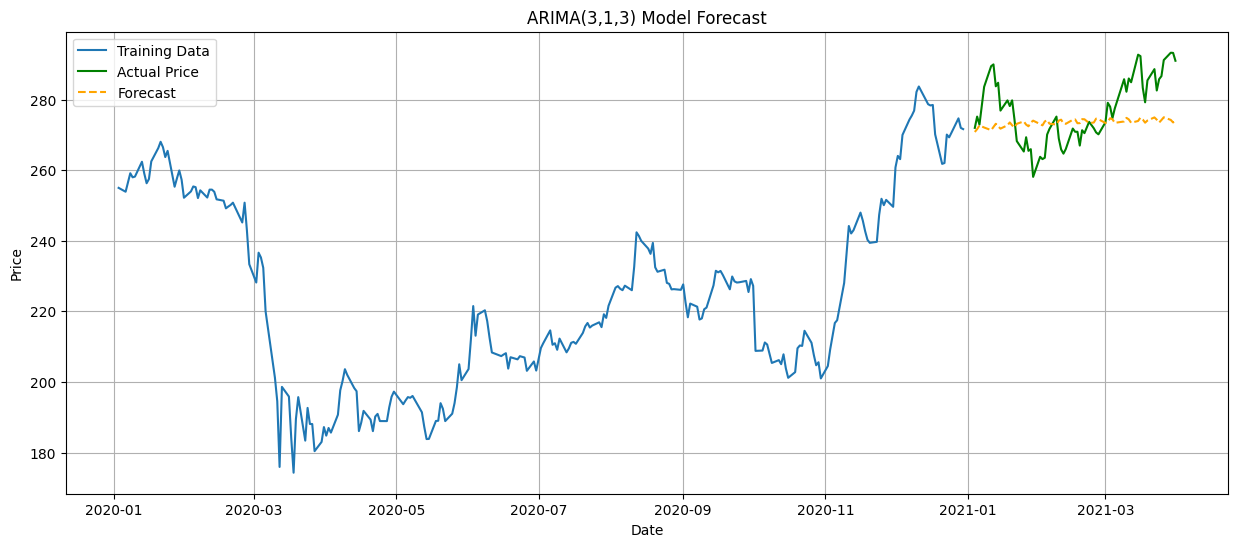


Accessing individual metrics:
RMSE: 9.59


In [ ]:
# Assuming you have your model fitted
results = evaluate_and_visualize_model(
    model=arima_best_model,
    train=train,
    test=test,
    model_name="ARIMA(3,1,3)",  # Or whatever your model order is
)

# Access metrics if needed
print("\nAccessing individual metrics:")
print(f"RMSE: {results['metrics']['rmse']:.2f}")

# Access forecast series if needed
forecast_series = results["forecast"]

### SARIMA Training


In [ ]:
import itertools
import warnings
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")


def evaluate_sarima_model(train_data, test_data, order, seasonal_order):
    """
    Evaluate a SARIMA model for given order (p,d,q) and seasonal_order (P,D,Q,s) and return RMSE
    """
    try:
        model = SARIMAX(
            train_data,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=len(test_data))
        rmse = np.sqrt(mean_squared_error(test_data, forecast))
        return rmse
    except:
        return float("inf")


def grid_search_sarima(
    train_data,
    test_data,
    p_values,
    d_values,
    q_values,
    P_values,
    D_values,
    Q_values,
    s_values,
):
    """
    Grid search for optimal SARIMA parameters
    """
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    best_model = None

    print("Starting Grid Search for SARIMA...")
    print("-" * 50)

    for p, d, q in itertools.product(p_values, d_values, q_values):
        for P, D, Q, s in itertools.product(P_values, D_values, Q_values, s_values):
            order = (p, d, q)
            seasonal_order = (P, D, Q, s)

            try:
                rmse = evaluate_sarima_model(
                    train_data, test_data, order, seasonal_order
                )
                if rmse < best_score:
                    best_score = rmse
                    best_order = order
                    best_seasonal_order = seasonal_order
                    # Save the best model
                    model = SARIMAX(
                        train_data,
                        order=best_order,
                        seasonal_order=best_seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                    )
                    best_model = model.fit(disp=False)
                # print(f'SARIMA{order}x{seasonal_order} - RMSE: {rmse:.3f}')
            except:
                continue

    return best_order, best_seasonal_order, best_score, best_model


# Define the parameter grid
p_values = range(0, 4)  # p: 0-2
d_values = range(1, 2)  # d: 1
q_values = range(0, 4)  # q: 0-2

# Seasonal parameters
P_values = range(0, 2)  # P: 0-1
D_values = range(0, 2)  # D: 0-1
Q_values = range(0, 2)  # Q: 0-1
s_values = [5, 15, 30]  # s: period (e.g., 5 for weekly, as we have daily data)

# Perform grid search
best_order, best_seasonal_order, best_score, sarima_best_model = grid_search_sarima(
    train["Price"],
    test["Price"],
    p_values,
    d_values,
    q_values,
    P_values,
    D_values,
    Q_values,
    s_values,
)

print("\nBest SARIMA Model:")
print("-" * 50)
print(f"Order (p,d,q): {best_order}")
print(f"Seasonal Order (P,D,Q,s): {best_seasonal_order}")
print(f"RMSE: {best_score:.3f}")

Starting Grid Search for SARIMA...
--------------------------------------------------

Best SARIMA Model:
--------------------------------------------------
Order (p,d,q): (1, 1, 3)
Seasonal Order (P,D,Q,s): (0, 1, 1, 15)
RMSE: 8.243



SARIMA(1, 1, 3)(0, 1, 1, 15) Model Performance Metrics:
--------------------------------------------------
Mean Squared Error (MSE): 67.95
Root Mean Squared Error (RMSE): 8.24
Mean Absolute Error (MAE): 6.98
Mean Absolute Percentage Error (MAPE): 2.53%
R-squared (R2): 0.1786


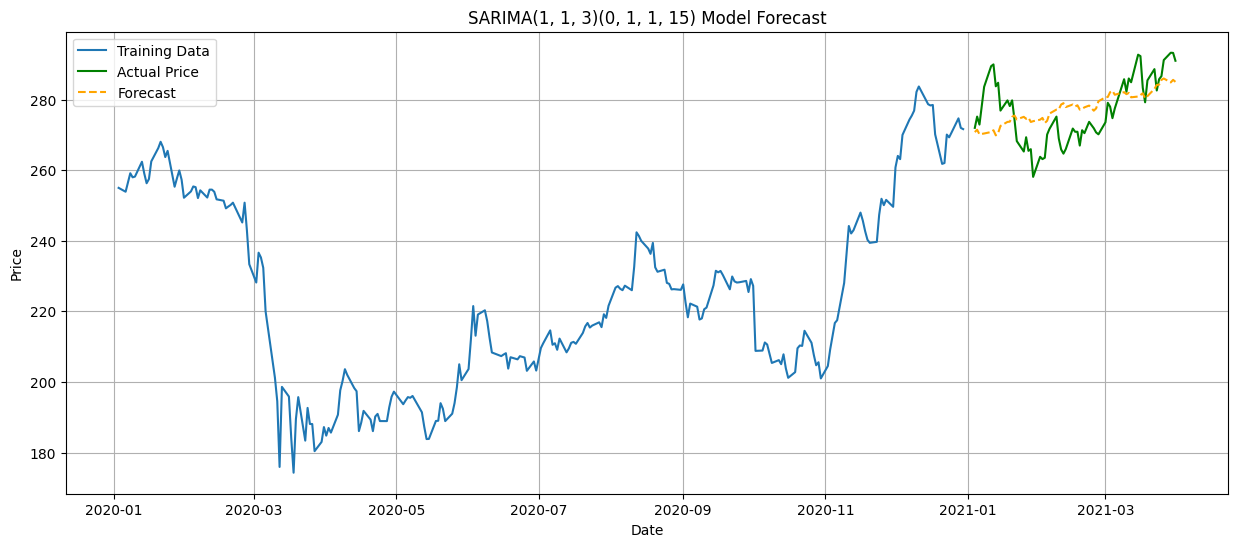


Accessing individual metrics:
RMSE: 8.24


In [ ]:
# Assuming you have your model fitted
results = evaluate_and_visualize_model(
    model=sarima_best_model,
    train=train,
    test=test,
    model_name="SARIMA(1, 1, 3)(0, 1, 1, 15)",  # Or whatever your model order is
)

# Access metrics if needed
print("\nAccessing individual metrics:")
print(f"RMSE: {results['metrics']['rmse']:.2f}")

# Access forecast series if needed
forecast_series = results["forecast"]

### ARIMAX Training


In [ ]:
import itertools
import warnings
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")


def evaluate_arimax_model(train_data, test_data, exog_train, exog_test, order):
    """
    Evaluate an ARIMAX model for given order (p,d,q) and return RMSE
    """
    try:
        model = SARIMAX(
            train_data,
            exog=exog_train,
            order=order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=len(test_data), exog=exog_test)
        rmse = np.sqrt(mean_squared_error(test_data, forecast))
        return rmse
    except:
        return float("inf")


def grid_search_arimax(
    train_data, test_data, exog_train, exog_test, p_values, d_values, q_values
):
    """
    Grid search for optimal ARIMAX parameters
    """
    best_score, best_order = float("inf"), None
    best_model = None

    print("Starting Grid Search for ARIMAX...")
    print("-" * 50)

    for p, d, q in itertools.product(p_values, d_values, q_values):
        order = (p, d, q)
        try:
            rmse = evaluate_arimax_model(
                train_data, test_data, exog_train, exog_test, order
            )
            if rmse < best_score:
                best_score = rmse
                best_order = order
                # Save the best model
                model = SARIMAX(
                    train_data,
                    exog=exog_train,
                    order=best_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )
                best_model = model.fit(disp=False)
            # print(f'ARIMAX{order} - RMSE: {rmse:.3f}')
        except:
            continue

    return best_order, best_score, best_model


# Prepare exogenous variables
exog_columns = ["Open", "High", "Low", "Vol."]
exog_train = train[exog_columns]
exog_test = test[exog_columns]

# Define the parameter grid
p_values = range(0, 4)  # p: 0-2
d_values = range(1, 2)  # d: 1 (based on your differencing plot)
q_values = range(0, 4)  # q: 0-2

# Perform grid search
best_order, best_score, arimax_best_model = grid_search_arimax(
    train["Price"], test["Price"], exog_train, exog_test, p_values, d_values, q_values
)

print("\nBest ARIMAX Model:")
print("-" * 50)
print(f"Order (p,d,q): {best_order}")
print(f"RMSE: {best_score:.3f}")

# Get model summary
print("\nModel Summary:")
print(arimax_best_model.summary())

Starting Grid Search for ARIMAX...
--------------------------------------------------

Best ARIMAX Model:
--------------------------------------------------
Order (p,d,q): (1, 1, 3)
RMSE: 2.378

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  250
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -523.163
Date:                Wed, 29 Jan 2025   AIC                           1064.326
Time:                        12:56:52   BIC                           1095.837
Sample:                             0   HQIC                          1077.016
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------



ARIMAX(2, 1, 1) Model Performance Metrics:
--------------------------------------------------
Mean Squared Error (MSE): 5.66
Root Mean Squared Error (RMSE): 2.38
Mean Absolute Error (MAE): 1.93
Mean Absolute Percentage Error (MAPE): 0.69%
R-squared (R2): 0.9316


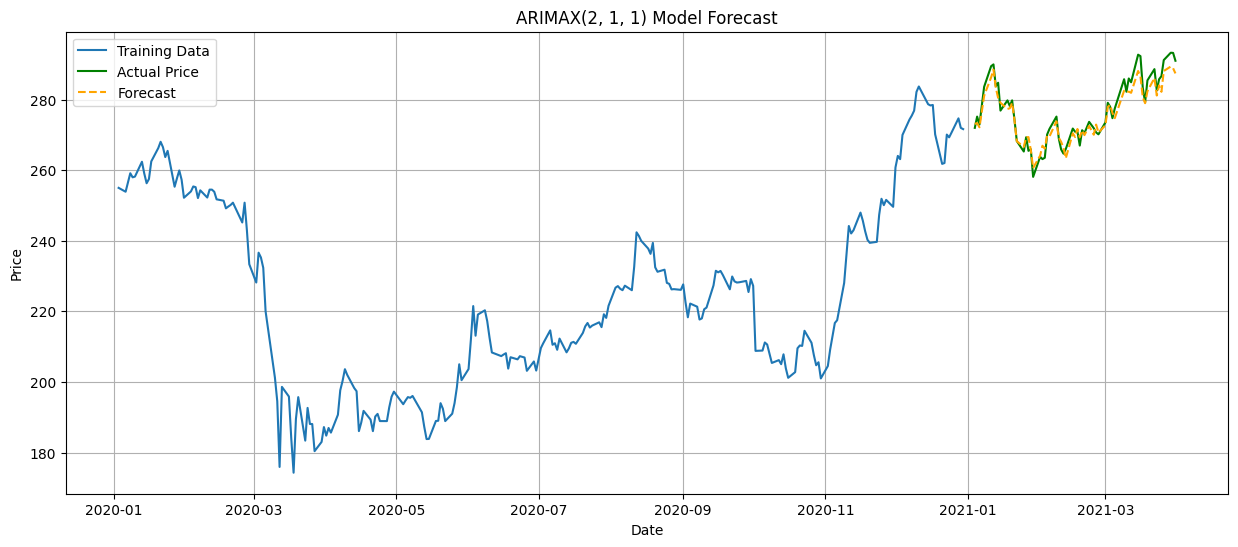


Accessing individual metrics:
RMSE: 2.38


In [ ]:
exog_columns = ["Open", "High", "Low", "Vol."]
results = evaluate_and_visualize_model(
    model=arimax_best_model,
    train=train,
    test=test,
    exog_test=test[exog_columns],
    model_name="ARIMAX(2, 1, 1)",
)
# Access metrics if needed
print("\nAccessing individual metrics:")
print(f"RMSE: {results['metrics']['rmse']:.2f}")

# Access forecast series if needed
forecast_series = results["forecast"]

# ML models


# LLM


## Prepare data for LLM


In [ ]:
# Set 'Date' as the index and sort the data
df.set_index("Date", inplace=True)
df = df.sort_index()

# Ensure the data is in the correct order
df = df.sort_values("Date")
# Split data into training (2020) and testing (2021) sets
train = df[df.index.year == 2020].copy()
test = df[df.index.year == 2021].copy()

In [ ]:
train

,Company,Price,Open,High,Low,Vol.,Change %
Date,,,,,,,
2020-01-03,Russia - Sberbank Rossii PAO (S,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-01-06,Russia - Sberbank Rossii PAO (S,253.90,254.75,254.84,251.40,22350000.0,-0.0043
2020-01-08,Russia - Sberbank Rossii PAO (S,259.15,253.57,259.15,253.03,40820000.0,0.0207
2020-01-09,Russia - Sberbank Rossii PAO (S,257.99,259.40,261.76,257.01,38330000.0,-0.0045
2020-01-10,Russia - Sberbank Rossii PAO (S,258.19,257.86,259.25,256.88,18850000.0,0.0008
...,...,...,...,...,...,...,...
2020-12-24,Russia - Sberbank Rossii PAO (S,269.32,271.98,272.82,267.13,42610000.0,-0.0029
2020-12-25,Russia - Sberbank Rossii PAO (S,270.64,269.97,271.00,268.28,11990000.0,0.0049
2020-12-28,Russia - Sberbank Rossii PAO (S,274.70,270.90,275.19,269.73,39040000.0,0.0150


In [ ]:
len(test)

61

In [ ]:
from io import StringIO


def convert_to_csv_string(timeseries):
    timeseries = timeseries[["Price", "Change %"]]
    timeseries = timeseries.rename(columns={"Change %": "pct_change"})
    timeseries = timeseries.reset_index()

    timeseries["pct_change"] = np.round(timeseries["pct_change"], 6)

    # Remove final row
    timeseries = timeseries.iloc[:-1]
    # timeseries.to_csv('timeseries.csv', index=True)
    # Convert DataFrame to CSV string
    csv_buffer = StringIO()
    timeseries.to_csv(csv_buffer, index=False)
    csv_string = csv_buffer.getvalue()

    return csv_string


df_for_llm = convert_to_csv_string(train)
print(df_for_llm)


Date,Price,pct_change
2020-01-03,255.0,0.001
2020-01-06,253.9,-0.0043
2020-01-08,259.15,0.0207
2020-01-09,257.99,-0.0045
2020-01-10,258.19,0.0008
2020-01-13,262.4,0.0163
2020-01-14,259.05,-0.0128
2020-01-15,256.31,-0.0106
2020-01-16,257.51,0.0047
2020-01-17,262.5,0.0194
2020-01-20,266.28,0.0144
2020-01-21,268.06,0.0067
2020-01-22,266.54,-0.0057
2020-01-23,263.73,-0.0105
2020-01-24,265.49,0.0067
2020-01-27,255.32,-0.0383
2020-01-28,257.7,0.0093
2020-01-29,259.94,0.0087
2020-01-30,257.31,-0.0101
2020-01-31,252.2,-0.0199
2020-02-03,253.99,0.0071
2020-02-04,255.4,0.0056
2020-02-05,255.2,-0.0008
2020-02-06,252.11,-0.0121
2020-02-07,254.3,0.0087
2020-02-10,252.26,-0.008
2020-02-11,254.5,0.0089
2020-02-12,254.5,0.0
2020-02-13,253.89,-0.0024
2020-02-14,251.75,-0.0084
2020-02-17,251.36,-0.0015
2020-02-18,249.2,-0.0086
2020-02-19,249.7,0.002
2020-02-20,250.15,0.0018
2020-02-21,250.8,0.0026
2020-02-25,245.19,-0.0224
2020-02-26,250.8,0.0229
2020-02-27,242.88,-0.0316
2020-02-28,233.36,-0.0392
2020-

In [ ]:
train.to_csv("train.csv", index=True)
test.to_csv("test.csv", index=True)

In [ ]:
test

,Company,Price,Open,High,Low,Vol.,Change %
Date,,,,,,,
2021-01-04,Russia - Sberbank Rossii PAO (S,272.00,274.67,276.60,270.61,48920000.0,0.0013
2021-01-05,Russia - Sberbank Rossii PAO (S,275.20,272.69,275.70,270.28,45580000.0,0.0118
2021-01-06,Russia - Sberbank Rossii PAO (S,272.93,275.94,275.94,271.62,40950000.0,-0.0082
2021-01-08,Russia - Sberbank Rossii PAO (S,283.64,275.11,283.99,275.11,88930000.0,0.0392
2021-01-11,Russia - Sberbank Rossii PAO (S,289.49,282.86,292.95,279.48,112350000.0,0.0206
...,...,...,...,...,...,...,...
2021-03-25,Russia - Sberbank Rossii PAO (S,286.66,286.50,287.03,283.85,35220000.0,0.0030
2021-03-26,Russia - Sberbank Rossii PAO (S,291.22,288.63,292.75,288.32,56070000.0,0.0159
2021-03-29,Russia - Sberbank Rossii PAO (S,293.30,289.72,294.09,289.26,43680000.0,0.0071


## Run LLM


In [ ]:
## Note: Change the date of the prediction/forecast for your own use (here, 2024-06-28)

# def predict_timeseries(timeseries, days_to_predict, start_predicted_date):
#     # output = llm.invoke(f"""
#     #     You are a large language model with time series forecasting capabilities.
#     #     Predict the price for the 15 days immediately after the end of the provided time series .
#     #     Use only your model capabilities, not any other method.
#     #     The data is in the format of a csv file.
#     #     The dataset includes:
#     #     - Date
#     #     - Stocke price
#     #     - Percent change in the stock price from the previous day
#     #     Provide only the forecasted the price and percent change for 15 days after as a point estimate.
#     #     Do not include any other text or context, just the 61 values:
#     #     {timeseries}
#     # """)
#     output = llm.invoke(f"""You are a stock price prediction assistant. Respond only with numbers.
#                         Based on this sequence of stock closing prices over the year 2020 : {timeseries},
#                         predict the closing prices on the nect {days_to_predict} days into the future satarted from {start_predicted_date} .
#                         Respond only with the daya and the predicted prices .""")
#     return output.strip()
def predict_timeseries(
    timeseries, days_to_predict, start_predicted_date, temperature=0
):
    """
    Predicts future stock prices based on an input time series and returns the predictions in CSV format.
    The CSV string includes the headers "Date,Price".

    Parameters:
      timeseries (str): The input time series data as a CSV-formatted string.
      days_to_predict (int): The number of days to forecast.
      start_predicted_date (str): The starting date for forecasting in 'YYYY-MM-DD' format.

    Returns:
      str: A CSV-formatted string with the headers "Date,Price" followed by the predicted values.
    """
    output = llm.invoke(
        # f"""You are a stock price prediction assistant. Respond only with numbers.
        # Based on this sequence of stock closing prices over the year 2020 : {timeseries},
        # predict the closing prices on the next {days_to_predict} days into the future starting from {start_predicted_date}.
        # Respond only with the date and the predicted price separated by a comma, one prediction per line.
        # Respond only with the following CSV format:
        # Date,Price
        # {start_predicted_date},predicted_price
        # ..."""
        f"""You are a stock price prediction assistant.
Based on this sequence of stock closing prices over the year 2020: {timeseries},
predict the closing prices on the next {days_to_predict} days starting from {start_predicted_date}.
INstructions :
- Do NOT output any chain-of-thought or internal reasoning.
- Respond ONLY with the predictions in CSV format.
- The first line should be the CSV header "Date,Price".
- Each subsequent line should contain a date and a predicted price separated by a comma. 
- Date must be in this format yyyy-mm-dd. 

""",
        temperature=temperature,
    )

    # Ensure the output is stripped of extra whitespace and prepend the CSV header.
    csv_output = "Date,Price\n" + output.strip()
    return csv_output


In [ ]:
df_for_llm

'Date,Price,pct_change\r\n2020-01-03,255.0,0.001\r\n2020-01-06,253.9,-0.0043\r\n2020-01-08,259.15,0.0207\r\n2020-01-09,257.99,-0.0045\r\n2020-01-10,258.19,0.0008\r\n2020-01-13,262.4,0.0163\r\n2020-01-14,259.05,-0.0128\r\n2020-01-15,256.31,-0.0106\r\n2020-01-16,257.51,0.0047\r\n2020-01-17,262.5,0.0194\r\n2020-01-20,266.28,0.0144\r\n2020-01-21,268.06,0.0067\r\n2020-01-22,266.54,-0.0057\r\n2020-01-23,263.73,-0.0105\r\n2020-01-24,265.49,0.0067\r\n2020-01-27,255.32,-0.0383\r\n2020-01-28,257.7,0.0093\r\n2020-01-29,259.94,0.0087\r\n2020-01-30,257.31,-0.0101\r\n2020-01-31,252.2,-0.0199\r\n2020-02-03,253.99,0.0071\r\n2020-02-04,255.4,0.0056\r\n2020-02-05,255.2,-0.0008\r\n2020-02-06,252.11,-0.0121\r\n2020-02-07,254.3,0.0087\r\n2020-02-10,252.26,-0.008\r\n2020-02-11,254.5,0.0089\r\n2020-02-12,254.5,0.0\r\n2020-02-13,253.89,-0.0024\r\n2020-02-14,251.75,-0.0084\r\n2020-02-17,251.36,-0.0015\r\n2020-02-18,249.2,-0.0086\r\n2020-02-19,249.7,0.002\r\n2020-02-20,250.15,0.0018\r\n2020-02-21,250.8,0.0026\r

In [ ]:
days_to_predict = 10
start_predicted_date = "2021-01-04"
llm = Ollama(model="deepseek-r1:14b", temperature=0)

print(
    predict_timeseries(df_for_llm, days_to_predict, start_predicted_date, temperature=0)
)

<think>
Okay, so I need to figure out how to predict the closing prices for the next 10 days based on the historical data provided. Let me start by looking at the data given.

The user has listed a series of dates and corresponding closing prices from September 2020 up until December 28, 2020. The last entry is on December 29, 2020, with no price given after that. The task is to predict the closing prices for the next 10 days after this point.

First, I should note that the data goes up to December 29, 2020. So, the next day would be January 1, 2021, and we need predictions up to January 10, 2021. That's 10 days in total.

Looking at the historical data, I can see that the prices have been fluctuating. There are periods of increase and decrease. For example, from November 30 to December 1, there's a significant jump from 249.63 to 260.81, which is an increase of about 5%. Then, on December 2, the price goes up again by around 1%, but drops slightly on December 3 and then increases agai

Based on this sequence of stock closing prices over the last {window} days: {prices}, predict the closing price {days} days into the future. Respond only with the predicted price between <prediction></prediction> tags.


In [ ]:
days_to_predict = 5
start_predicted_date = "2021-01-04"
llm = Ollama(model="deepseek-r1:1.5b", temperature=0)

ds_predictions = predict_timeseries(
    df_for_llm, days_to_predict, start_predicted_date, temperature=0
)
print(ds_predictions)

Date,Price
<think>
Okay, so I need to predict the closing prices for the next 5 days starting from January 4, 2021. The data provided is in a CSV format with dates and corresponding prices. Let me see how I can approach this.

First, I should probably parse the given data into a structured format where each row has a date and a price. Looking at the input, it's comma-separated, so that's straightforward. Each line alternates between a date and a price, like "2021-01-03,5.0; 2021-01-04,6.0;" etc.

I think I can split this into two columns: one for dates and another for prices. Then, I need to predict the next five days starting from January 4, 2021. So that would be January 5, 6, 7, 8, and 9, each with their respective predicted prices.

Wait, but how do I get these predictions? The user didn't provide any model or method for prediction. Maybe the data is from a time series, so perhaps I can use some kind of forecasting technique like moving averages or exponential smoothing. Alternativ

In [ ]:
days_to_predict = 5
start_predicted_date = "2021-01-04"
llm = Ollama(model="deepseek-r1:8b", temperature=0)

ds_predictions = predict_timeseries(
    df_for_llm, days_to_predict, start_predicted_date, temperature=0
)
print(ds_predictions)

Date,Price
<think>
Alright, so I need to predict the closing prices for the next five days starting from January 4th, 2021. The user provided a list of historical closing prices from 2020 onwards up until December 31st, 2020. My task is to use this data to forecast the prices for each subsequent day.

First, I should look at the data structure. Each line has a date and the corresponding closing price. The dates start from January 4th, 2021, but wait, actually, looking closely, the last date provided in the input is December 31st, 2020. So, starting from January 4th, 2021, I need to predict five days after that.

Wait, no, the user says "starting from 2021-01-04," so the first prediction is for 2021-01-05, then up to 2021-01-09. But looking at the example output, it's only one date and price per line, so I think each subsequent day after January 4th needs a prediction.

But wait, the data provided goes up to December 31st, 2020. So from January 4th, 2021, there are no historical prices.

In [ ]:
ds_predictions = re.sub(
    r"<think>.*?</think>", "", ds_predictions, flags=re.DOTALL
).strip()
print(ds_predictions)

Date,Price


To predict the next five closing prices starting from January 4th, 2021, based on the provided historical data, we can use a simple linear regression model. Here's a step-by-step explanation:

### Step 1: Data Preparation
- **Assign Time Values:** Convert each date into a numerical time value (e.g., November 30th is day 1, December 1st is day 2, etc.).
- **Identify Gaps:** Note the missing data points between December 25th and January 4th.

### Step 2: Model Building
- **Linear Regression:** Use time as the independent variable and closing price as the dependent variable to fit a linear regression model.
- **Trend Analysis:** Calculate the trend (slope) from November to December to project future prices.

### Step 3: Prediction
- **Extend the Model:** Project the linear regression line forward for five days starting from January 4th, considering the identified trend.

### Conclusion:
Given the limitations of the data and potential external factors, a simple linear regressi

In [ ]:
days_to_predict = 10
start_predicted_date = "2021-01-04"
llm = Ollama(model="llama3.2:latest", temperature=0)
# ("deepseek-r1:7b", "Deepseek")
llama3_predictions = predict_timeseries(
    df_for_llm, days_to_predict, start_predicted_date
)
print(llama3_predictions)


Date,Price
2021-01-04,283.73
2021-01-05,286.19
2021-01-06,288.35
2021-01-07,290.31
2021-01-08,292.17
2021-01-09,293.93
2021-01-10,295.59
2021-01-11,297.15
2021-01-12,298.71
2021-01-13,300.27


In [ ]:
days_to_predict = 10
start_predicted_date = "2021-01-04"
llm = Ollama(model="qwen2.5:3b", temperature=0)
# ("deepseek-r1:7b", "Deepseek")
qween_predictions = predict_timeseries(
    df_for_llm, days_to_predict, start_predicted_date
)
print(qween_predictions)

Date,Price
2021-01-04,274.85
2021-01-05,273.69
2021-01-06,272.53
2021-01-07,271.37
2021-01-08,270.21
2021-01-09,269.05
2021-01-10,267.89
2021-01-11,266.73
2021-01-14,265.57


In [ ]:
import pandas as pd
import numpy as np
import io
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def compare_predictions_metrics_csv(prediction_csv, test_df):
    """
    Reads predictions from a CSV-formatted string and compares them with real prices from test_df based on matching dates.
    Returns a CSV-formatted string containing evaluation metrics: MAE, MSE, RMSE, R2.

    If the "Date" is stored as the DataFrame index in test_df, this function will convert it into a column.

    Parameters:
      prediction_csv (str): CSV string with header "Date,Price" containing the predicted prices.
      test_df (pd.DataFrame): DataFrame with at least "Price" column and date information stored either in a column named
                              "Date" or as the DataFrame index.

    Returns:
      str: A CSV string of the evaluation metrics with headers "Metric,Value".
    """
    # If "Date" is not a column, assume it's the index and reset it.
    if "Date" not in test_df.columns:
        test_df = test_df.reset_index().rename(columns={"index": "Date"})

    # Read the predictions from the CSV string.
    pred_df = pd.read_csv(io.StringIO(prediction_csv.strip()))

    # Ensure the Date columns are of type string for proper matching.
    pred_df["Date"] = pred_df["Date"].astype(str)
    test_df["Date"] = test_df["Date"].astype(str)

    # Use only the 'Date' and 'Price' columns from the test DataFrame.
    test_prices = test_df[["Date", "Price"]].copy()
    test_prices.rename(columns={"Price": "Price_real"}, inplace=True)
    pred_df.rename(columns={"Price": "Price_pred"}, inplace=True)

    # Merge predictions with the real prices based on the Date column.
    merged = pd.merge(pred_df, test_prices, on="Date", how="inner")
    print(merged)
    if merged.empty:
        raise ValueError("No matching dates found between predictions and test data.")

    # Extract the prediction and real price arrays.
    y_pred = merged["Price_pred"].values
    y_true = merged["Price_real"].values

    # Calculate evaluation metrics.
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Create a DataFrame for the metrics.
    metrics_df = pd.DataFrame(
        {"Metric": ["MAE", "MSE", "RMSE", "R2"], "Value": [mae, mse, rmse, r2]}
    )

    # Convert the metrics DataFrame to a CSV string (without the index).
    csv_metrics = metrics_df.to_csv(index=False)
    return csv_metrics


# Compute the evaluation metrics and get the result in CSV format.
metrics_csv = compare_predictions_metrics_csv(llama3_predictions, test)
print(metrics_csv)

         Date  Price_pred  Price_real
0  2021-01-05      275.21      275.20
1  2021-01-06      277.43      272.93
2  2021-01-08      281.87      283.64
3  2021-01-11      284.09      289.49
4  2021-01-12      286.31      289.99
5  2021-01-13      288.53      283.78
6  2021-01-14      290.75      284.79
7  2021-01-15      292.97      276.90
Metric,Value
MAE,5.267500000000005
MSE,47.80180000000021
RMSE,6.9138845810441625
R2,-0.3276784139562112



In [ ]:
llama3_predictions

'Date,Price\nHere are the predictions:\n\n2021-01-05, 275.21\n2021-01-06, 277.43\n2021-01-07, 279.65\n2021-01-08, 281.87\n2021-01-11, 284.09\n2021-01-12, 286.31\n2021-01-13, 288.53\n2021-01-14, 290.75\n2021-01-15, 292.97'

In [ ]:
test.index

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-08',
               '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14',
               '2021-01-15', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-22', '2021-01-25', '2021-01-26',
               '2021-01-27', '2021-01-28', '2021-01-29', '2021-02-01',
               '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05',
               '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11',
               '2021-02-12', '2021-02-15', '2021-02-16', '2021-02-17',
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-22',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12',
               '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18',
               '2021-03-19', '2021-03-22', '2021-03-23', '2021-03-24',
      

In [ ]:
days_to_predict = 10
start_predicted_date = "2021-01-04"
llm = Ollama(model="mistral:latest", temperature=0)

print(predict_timeseries(df_for_llm, days_to_predict, start_predicted_date))

Date,Price
2021-01-05, 271.5
2021-01-06, 270.8
2021-01-07, 270.3
2021-01-08, 269.8
2021-01-09, 269.3
2021-01-11, 268.8
2021-01-12, 268.3
2021-01-13, 267.8
2021-01-14, 267.3
2021-01-15, 266.8


In [ ]:
import pandas as pd
import numpy as np
import io
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import re


def clean_prediction_csv(csv_string):
    """
    Clean a CSV string by retaining only the header and rows that start with a valid date.
    Assumes the header is the first line and valid data rows start with something like '2021-'
    (adjust the regex if needed).
    """
    lines = csv_string.strip().splitlines()
    if not lines:
        return csv_string
    header = lines[0]
    # Regex to match a date-like pattern at the start of the string (e.g., 2021-)
    valid_line_pattern = re.compile(r"^\s*20\d\d-")
    valid_lines = [header] + [
        line for line in lines[1:] if valid_line_pattern.match(line)
    ]
    return "\n".join(valid_lines)


# List of models to compare.
# Each entry is a tuple: (model_api_name, display_name)
models = [
    ("mistral:latest", "Mistral"),
    # ("gemma2:latest", "Gemma2"),
    ("llama3:latest", "Llama3"),
    ("deepseek-r1:7b", "Deepseek"),
]

# Prediction configuration
days_to_predict = 10
start_predicted_date = "2021-01-04"

# Prepare empty collections:
# This dictionary will hold each model's predictions DataFrame, keyed by model display name.
predictions_dict = {}
# This list will store the computed evaluation metrics for each model.
metrics_results = []

# Ensure that test has the date in a column by resetting the index if necessary.
if "Date" not in test.columns:
    test = test.reset_index().rename(columns={"index": "Date"})

# Convert Date to string (for proper merging with predictions)
test["Date"] = test["Date"].astype(str)
# Keep only the Date and true Price (renamed later if needed)
test_prices = test[["Date", "Price"]].rename(columns={"Price": "Price_real"})

# Loop over each model, run predictions, compute metrics, and store the daily predictions.
for model_api, display_name in models:
    print("Running prediction for model:", display_name)
    # Initialize the model (using Ollama in this case)
    llm = Ollama(model=model_api, temperature=0)

    # Get predictions as CSV string for the current model.
    # We assume that predict_timeseries uses the current model (llm) internally.
    predictions_csv = predict_timeseries(
        df_for_llm, days_to_predict, start_predicted_date
    )

    # Clean the CSV string to remove extra text.
    predictions_csv_clean = clean_prediction_csv(predictions_csv)

    print("Cleaned Predictions for", display_name, ":\n", predictions_csv_clean)

    # Convert CSV string to a DataFrame.
    pred_df = pd.read_csv(io.StringIO(predictions_csv_clean.strip()))
    pred_df["Date"] = pred_df["Date"].astype(str).str.strip()

    # Merge the predictions with the test (true) prices for matching dates.
    merged = pd.merge(pred_df, test_prices, on="Date", how="inner")

    # In case there are no matching dates, skip the evaluation.
    if merged.empty:
        print(f"No matching dates found for model {display_name}")
        continue

    # Compute evaluation metrics using the true and predicted prices.
    y_true = merged["Price_real"].values
    y_pred = merged["Price"].values
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Record metrics for this model.
    metrics_results.append(
        {"Model": display_name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}
    )

    # For daily predictions comparison, rename the predicted Price column with the model name.
    pred_df = pred_df.rename(columns={"Price": display_name})

    # Add predictions to our dictionary.
    predictions_dict[display_name] = pred_df

# Combine daily predictions from all models.
# We'll merge on the "Date" column (inner join with only common dates).
daily_predictions_df = None
for model_name, df_model in predictions_dict.items():
    if daily_predictions_df is None:
        daily_predictions_df = df_model
    else:
        daily_predictions_df = pd.merge(
            daily_predictions_df, df_model[["Date", model_name]], on="Date", how="inner"
        )
daily_predictions_df = pd.merge(
    daily_predictions_df, test_prices, on="Date", how="inner"
)
# Create a metrics DataFrame.
metrics_df = pd.DataFrame(metrics_results)

# Optionally, sort the daily predictions by date.
daily_predictions_df = daily_predictions_df.sort_values(by="Date").reset_index(
    drop=True
)

# Display the results.
print("Daily Predictions per Model:")
print(daily_predictions_df)
print("\nEvaluation Metrics Comparison:")
print(metrics_df)

Running prediction for model: Mistral
Cleaned Predictions for Mistral :
 Date,Price
2021-01-05, 273.5
  2021-01-06, 274.0
  2021-01-07, 273.8
  2021-01-08, 273.5
  2021-01-09, 273.2
  2021-01-11, 272.8
  2021-01-12, 272.6
  2021-01-13, 272.4
  2021-01-14, 272.2
  2021-01-15, 272.0
Running prediction for model: Llama3
Cleaned Predictions for Llama3 :
 Date,Price
2021-01-05, 275.21
2021-01-06, 277.43
2021-01-07, 279.65
2021-01-08, 281.87
2021-01-11, 284.09
2021-01-12, 286.31
2021-01-13, 288.53
2021-01-14, 290.75
2021-01-15, 292.97
Running prediction for model: Deepseek
Cleaned Predictions for Deepseek :
 Date,Price
No matching dates found for model Deepseek
Daily Predictions per Model:
         Date  Mistral  Llama3  Price_real
0  2021-01-05    273.5  275.21      275.20
1  2021-01-06    274.0  277.43      272.93
2  2021-01-08    273.5  281.87      283.64
3  2021-01-11    272.8  284.09      289.49
4  2021-01-12    272.6  286.31      289.99
5  2021-01-13    272.4  288.53      283.78
6  202

In [ ]:
daily_predictions_df

,Date,Mistral,Llama3
0,2021-01-05,273.5,275.21


### Prophete training


16:14:05 - cmdstanpy - INFO - Chain [1] start processing
16:14:05 - cmdstanpy - INFO - Chain [1] done processing



Prophet Model Performance Metrics:
--------------------------------------------------
Training RMSE: 1.55
Test RMSE: 3.26
Test MAE: 2.74
Test MAPE: nan%
Test R2 Score: 0.8712


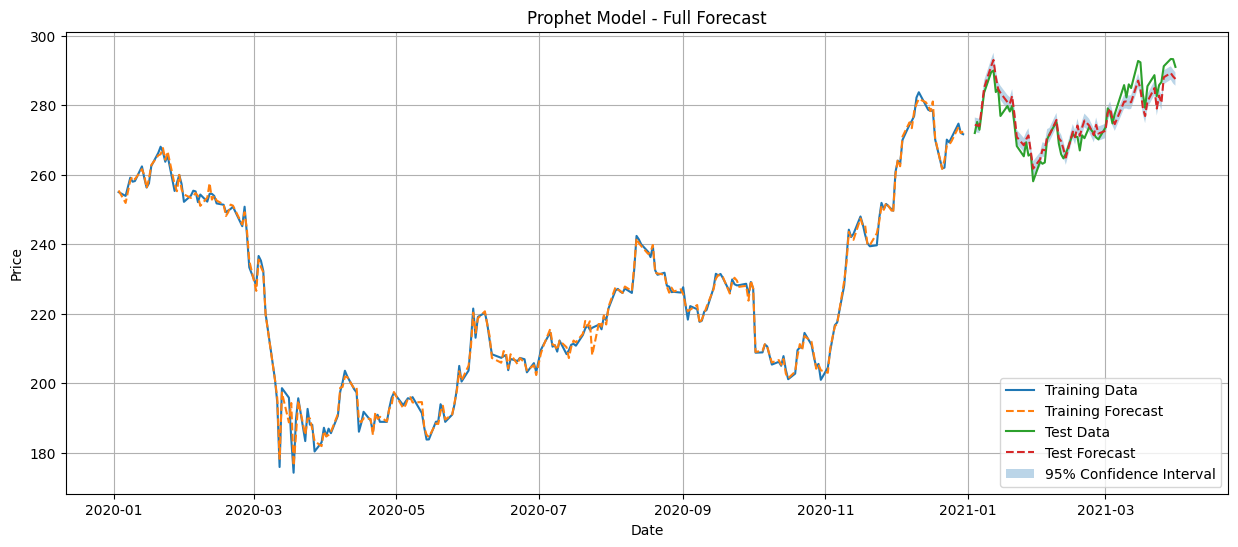

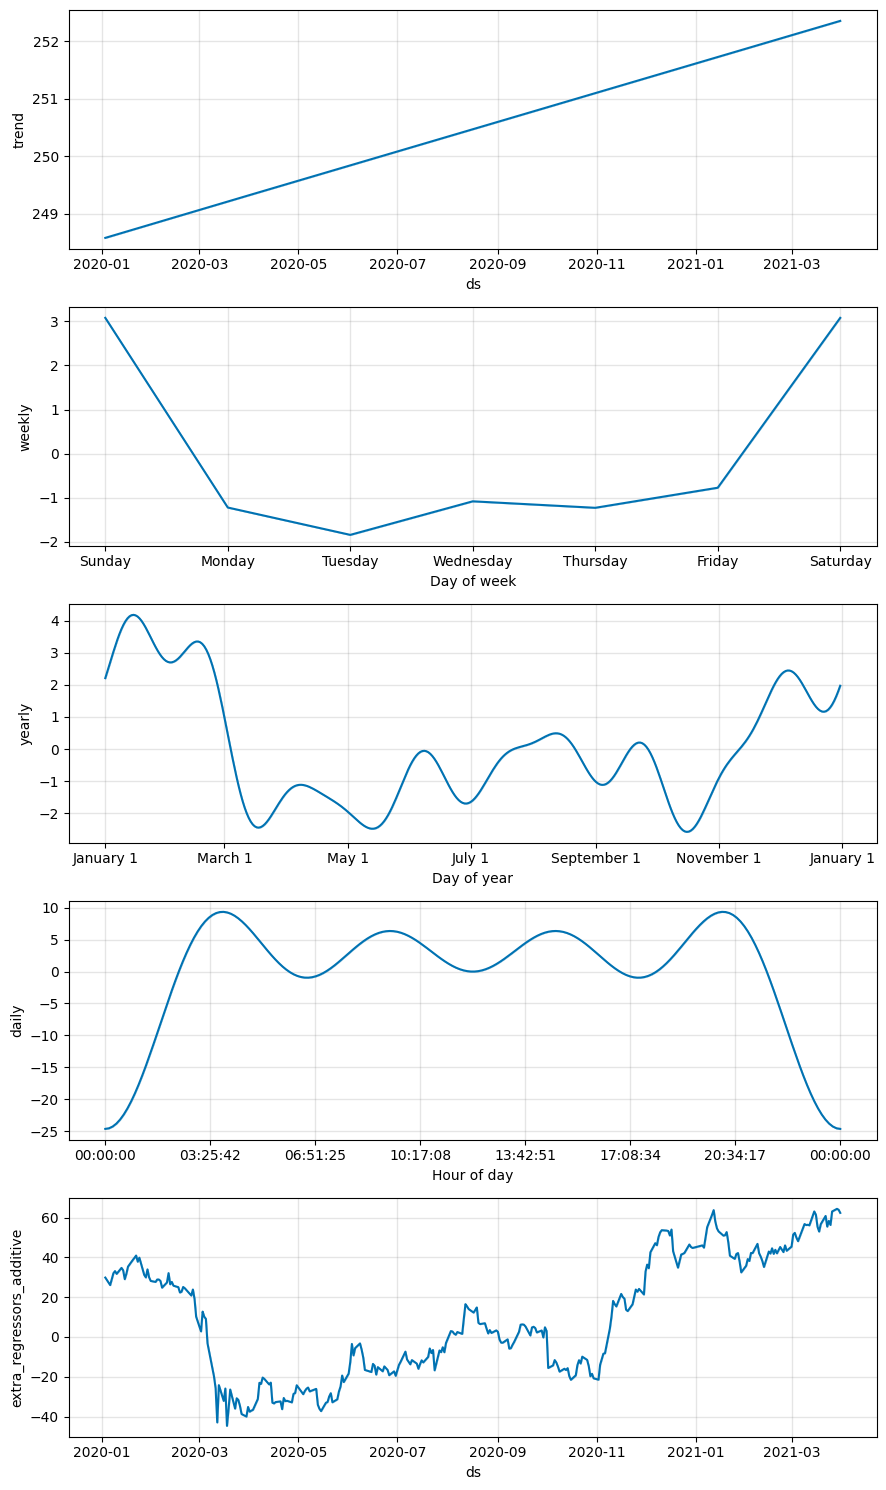

In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
def train_prophet_model(train, test, additional_regressors=None):
    """
    Train Prophet model and make predictions
    """
    # Prepare data for Prophet
    train_prophet = pd.DataFrame({"ds": train.index, "y": train["Price"]})

    test_prophet = pd.DataFrame({"ds": test.index, "y": test["Price"]})

    # Initialize and train Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10,
        holidays_prior_scale=10,
    )

    # Add additional regressors if provided
    if additional_regressors:
        for regressor in additional_regressors:
            model.add_regressor(regressor)
            train_prophet[regressor] = train[regressor]
            test_prophet[regressor] = test[regressor]

    # Fit the model
    model.fit(train_prophet)

    # Make predictions
    train_forecast = model.predict(train_prophet)
    test_forecast = model.predict(test_prophet)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(train["Price"], train_forecast["yhat"]))
    test_rmse = np.sqrt(mean_squared_error(test["Price"], test_forecast["yhat"]))
    test_mae = mean_absolute_error(test["Price"], test_forecast["yhat"])
    test_mape = (
        np.mean(np.abs((test["Price"] - test_forecast["yhat"]) / test["Price"])) * 100
    )
    test_r2 = r2_score(test["Price"], test_forecast["yhat"])

    # Print metrics
    print("\nProphet Model Performance Metrics:")
    print("-" * 50)
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Test MAPE: {test_mape:.2f}%")
    print(f"Test R2 Score: {test_r2:.4f}")

    # Plot 1: Forecast
    plt.figure(figsize=(15, 6))
    plt.plot(train.index, train["Price"], label="Training Data")
    plt.plot(train.index, train_forecast["yhat"], "--", label="Training Forecast")
    plt.plot(test.index, test["Price"], label="Test Data")
    plt.plot(test.index, test_forecast["yhat"], "--", label="Test Forecast")
    plt.fill_between(
        test.index,
        test_forecast["yhat_lower"],
        test_forecast["yhat_upper"],
        alpha=0.3,
        label="95% Confidence Interval",
    )
    plt.title("Prophet Model - Full Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Components
    model.plot_components(model.predict(pd.concat([train_prophet, test_prophet])))
    plt.show()

    return {
        "model": model,
        "predictions": {"train": train_forecast, "test": test_forecast},
        "metrics": {
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "test_mae": test_mae,
            "test_mape": test_mape,
            "test_r2": test_r2,
        },
    }


# Train the model
additional_regressors = ["Open", "High", "Low", "Vol."]
prophet_results = train_prophet_model(train, test, additional_regressors)

### LSTM TRaining


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2145 - val_loss: 0.6932
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1654 - val_loss: 0.5305
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0999 - val_loss: 0.2660
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0358 - val_loss: 0.0287
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0344 - val_loss: 0.0229
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0145 - val_loss: 0.0759
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0211 - val_loss: 0.0474
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0143 - val_loss: 0.0199
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0175 - val_loss: 0.0269
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0147 - val_loss: 0.0376
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0153 - val_loss: 0.0349
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0144 - val_lo

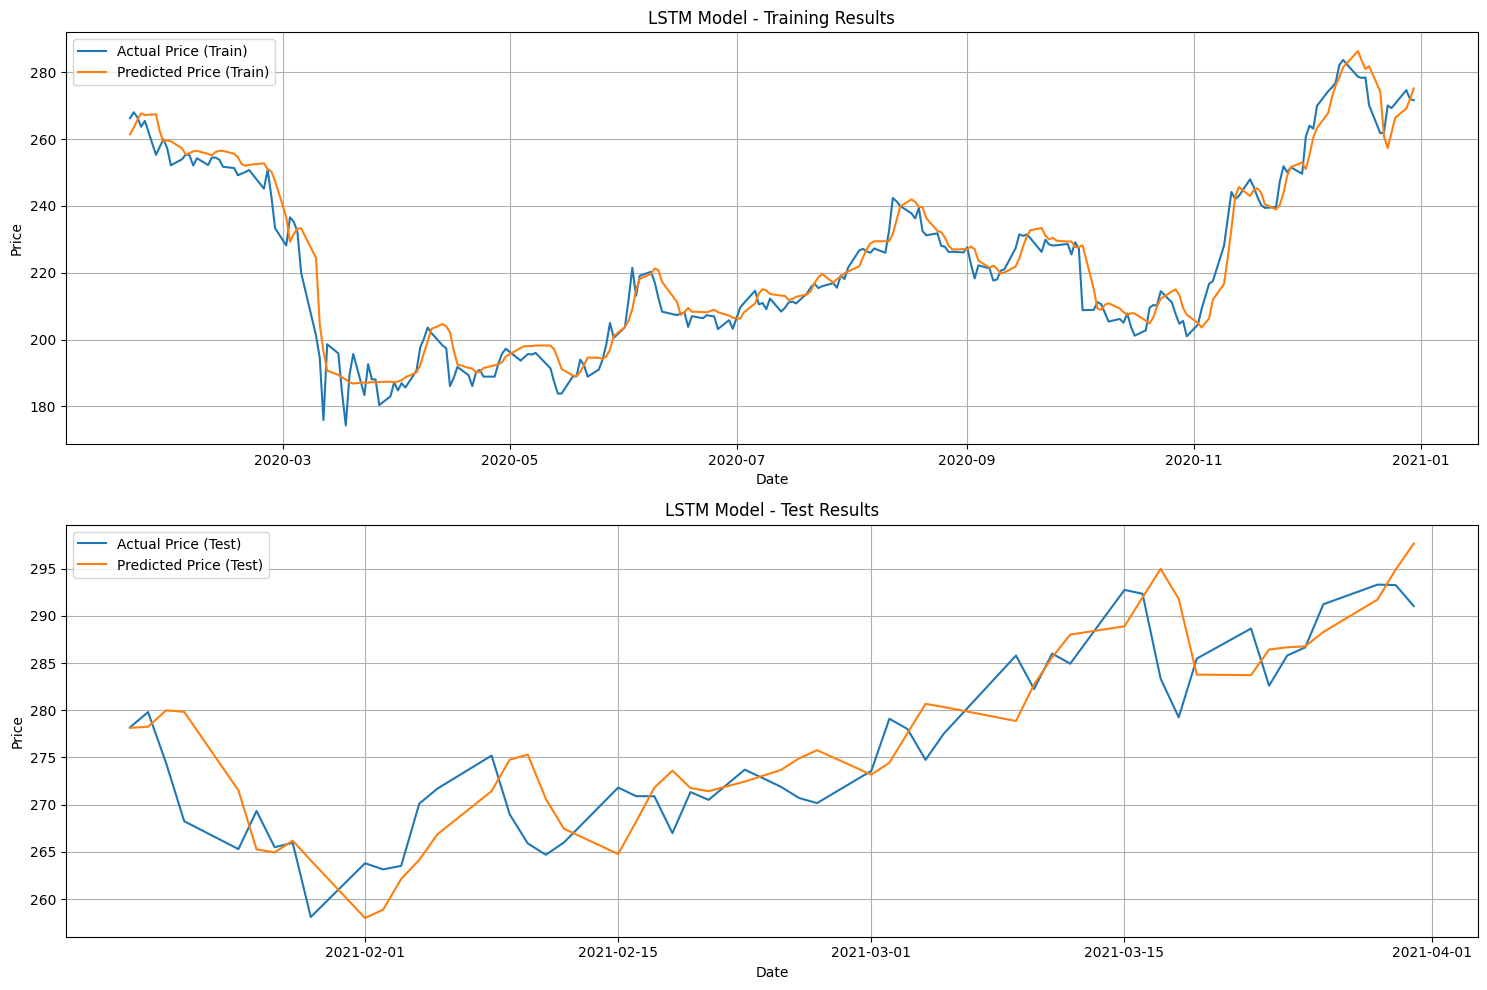

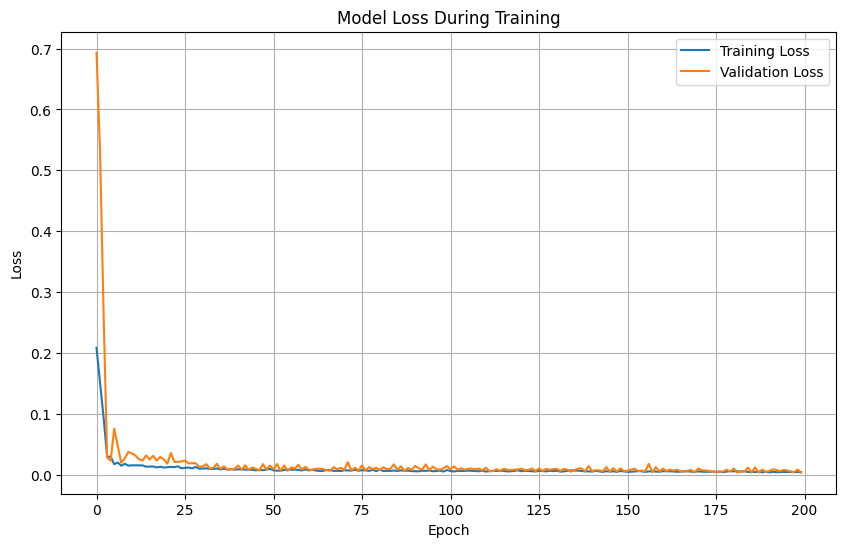

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def create_sequences(data, seq_length):
    """Create sequences for LSTM model"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : (i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


def build_lstm_model(seq_length, n_features):
    """Build LSTM model architecture"""
    model = Sequential(
        [
            LSTM(
                50,
                activation="relu",
                return_sequences=True,
                input_shape=(seq_length, n_features),
            ),
            Dropout(0.2),
            LSTM(50, activation="relu"),
            Dropout(0.2),
            Dense(1),
        ]
    )
    return model


def train_lstm_model(train, test, seq_length=10):
    """
    Train LSTM model and make predictions

    Parameters:
    -----------
    train : pandas DataFrame
        Training data
    test : pandas DataFrame
        Test data
    seq_length : int
        Sequence length for LSTM input

    Returns:
    --------
    dict
        Dictionary containing model, predictions, and metrics
    """
    # Prepare features
    features = ["Price", "Open", "High", "Low", "Vol."]

    # Scale the features
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train[features])
    test_scaled = scaler.transform(test[features])

    # Create sequences
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    # Build and compile model
    model = build_lstm_model(seq_length, len(features))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    # Train model
    history = model.fit(
        X_train,
        y_train[:, 0],
        epochs=200,
        batch_size=32,
        validation_split=0.1,
        verbose=1,
    )

    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Inverse transform predictions
    train_pred_reshaped = np.zeros((len(train_pred), len(features)))
    train_pred_reshaped[:, 0] = train_pred.flatten()
    test_pred_reshaped = np.zeros((len(test_pred), len(features)))
    test_pred_reshaped[:, 0] = test_pred.flatten()

    train_pred = scaler.inverse_transform(train_pred_reshaped)[:, 0]
    test_pred = scaler.inverse_transform(test_pred_reshaped)[:, 0]

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(train["Price"][seq_length:], train_pred))
    test_rmse = np.sqrt(mean_squared_error(test["Price"][seq_length:], test_pred))
    test_mae = mean_absolute_error(test["Price"][seq_length:], test_pred)
    test_mape = (
        np.mean(
            np.abs(
                (test["Price"][seq_length:] - test_pred) / test["Price"][seq_length:]
            )
        )
        * 100
    )
    test_r2 = r2_score(test["Price"][seq_length:], test_pred)

    # Print metrics
    print("\nLSTM Model Performance Metrics:")
    print("-" * 50)
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Test MAPE: {test_mape:.2f}%")
    print(f"Test R2 Score: {test_r2:.4f}")

    # Plot results
    plt.figure(figsize=(15, 10))

    # Plot 1: Training results
    plt.subplot(2, 1, 1)
    plt.plot(train["Price"][seq_length:], label="Actual Price (Train)")
    plt.plot(train.index[seq_length:], train_pred, label="Predicted Price (Train)")
    plt.title("LSTM Model - Training Results")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)

    # Plot 2: Test results
    plt.subplot(2, 1, 2)
    plt.plot(test["Price"][seq_length:], label="Actual Price (Test)")
    plt.plot(test.index[seq_length:], test_pred, label="Predicted Price (Test)")
    plt.title("LSTM Model - Test Results")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Model Loss During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "model": model,
        "predictions": {"train": train_pred, "test": test_pred},
        "metrics": {
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "test_mae": test_mae,
            "test_mape": test_mape,
            "test_r2": test_r2,
        },
        "history": history.history,
    }


# Train the model
lstm_results = train_lstm_model(train, test)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.2211 - val_loss: 0.2853
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0474 - val_loss: 0.0116
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0175 - val_loss: 0.0242
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0097 - val_loss: 0.0699
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_loss: 0.0165
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0075 - val_loss: 0.0131
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0079 - val_loss: 0.0261
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0056 - val_loss: 0.0090
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0053 - val_loss: 0.0127
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - val_loss: 0.0121
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0054 - val_loss: 0.0120
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - val_lo

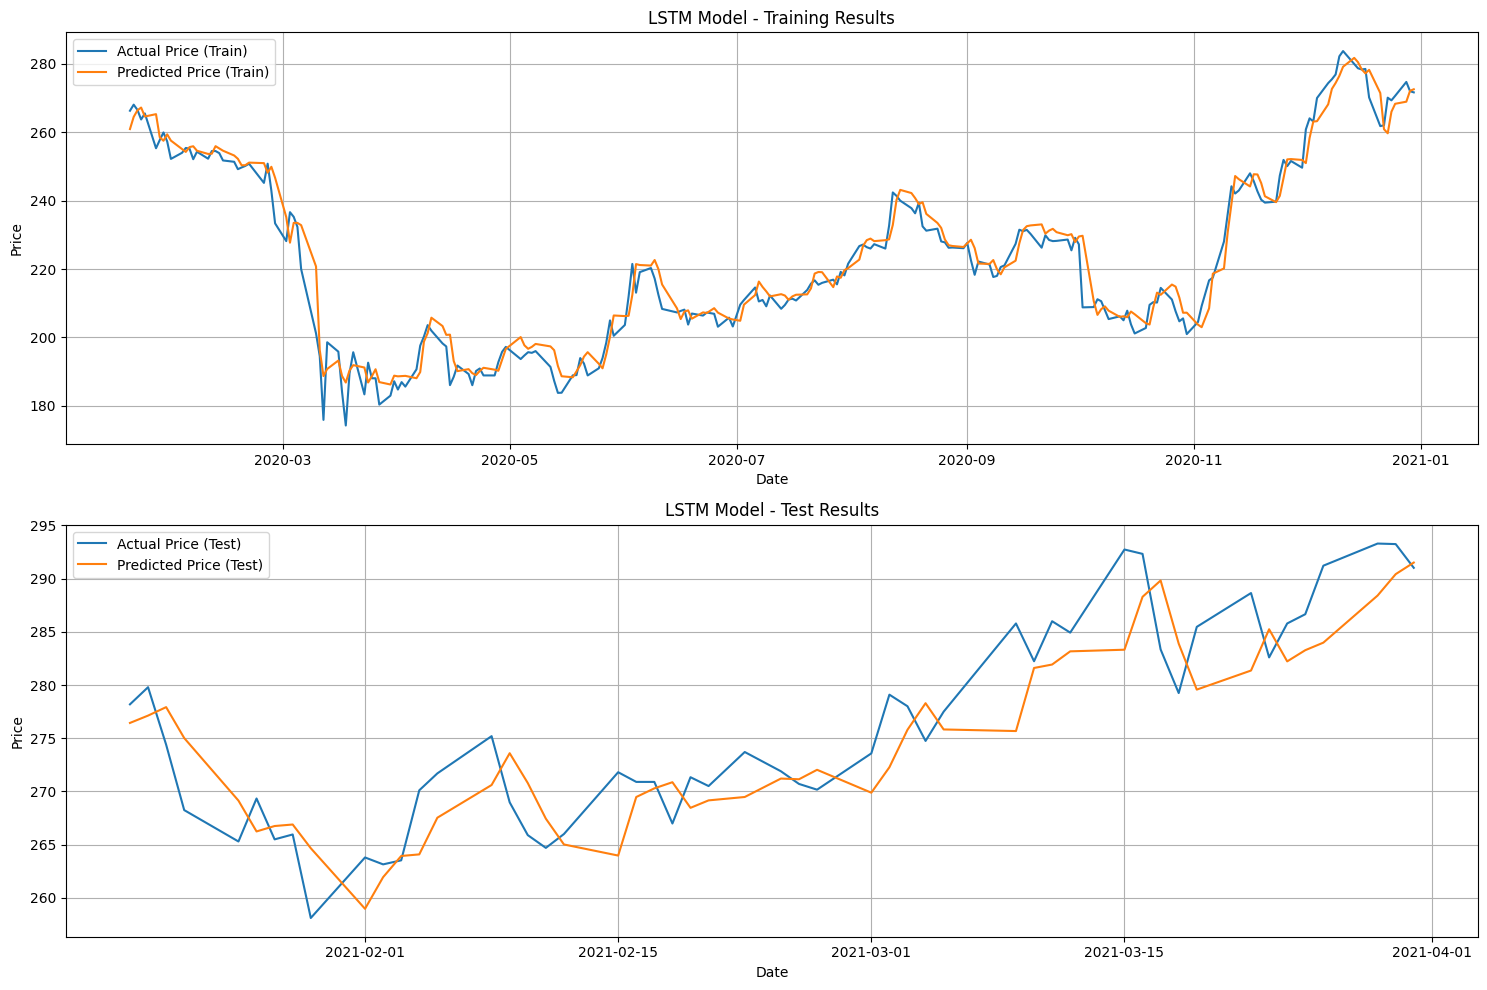

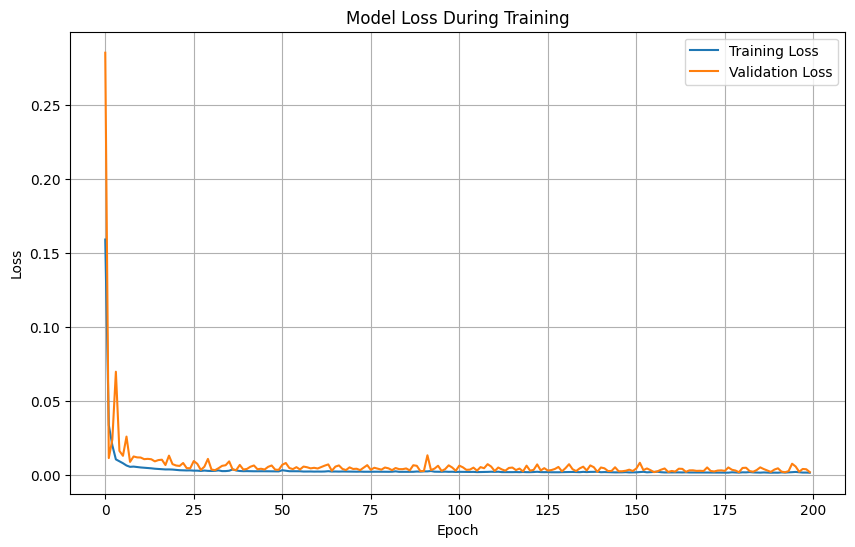

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def create_sequences(data, seq_length):
    """Create sequences for LSTM model"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : (i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


def build_lstm_model(seq_length, n_features):
    """Build LSTM model architecture"""
    # model = Sequential([
    #     LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, n_features)),
    #     Dropout(0.2),
    #     LSTM(50, activation='relu'),
    #     Dropout(0.2),
    #     Dense(1)
    # ])
    model = Sequential(
        [LSTM(64), Dense(32, activation="relu"), Dense(32, activation="relu"), Dense(1)]
    )
    return model


def train_lstm_model(train, test, seq_length=10):
    """
    Train LSTM model and make predictions

    Parameters:
    -----------
    train : pandas DataFrame
        Training data
    test : pandas DataFrame
        Test data
    seq_length : int
        Sequence length for LSTM input

    Returns:
    --------
    dict
        Dictionary containing model, predictions, and metrics
    """
    # Prepare features
    features = ["Price", "Open", "High", "Low", "Vol."]

    # Scale the features
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train[features])
    test_scaled = scaler.transform(test[features])

    # Create sequences
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    # Build and compile model
    model = build_lstm_model(seq_length, len(features))
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    # Train model
    history = model.fit(
        X_train,
        y_train[:, 0],
        epochs=200,
        batch_size=32,
        validation_split=0.1,
        verbose=1,
    )

    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Inverse transform predictions
    train_pred_reshaped = np.zeros((len(train_pred), len(features)))
    train_pred_reshaped[:, 0] = train_pred.flatten()
    test_pred_reshaped = np.zeros((len(test_pred), len(features)))
    test_pred_reshaped[:, 0] = test_pred.flatten()

    train_pred = scaler.inverse_transform(train_pred_reshaped)[:, 0]
    test_pred = scaler.inverse_transform(test_pred_reshaped)[:, 0]

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(train["Price"][seq_length:], train_pred))
    test_rmse = np.sqrt(mean_squared_error(test["Price"][seq_length:], test_pred))
    test_mae = mean_absolute_error(test["Price"][seq_length:], test_pred)
    test_mape = (
        np.mean(
            np.abs(
                (test["Price"][seq_length:] - test_pred) / test["Price"][seq_length:]
            )
        )
        * 100
    )
    test_r2 = r2_score(test["Price"][seq_length:], test_pred)

    # Print metrics
    print("\nLSTM Model Performance Metrics:")
    print("-" * 50)
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Test MAPE: {test_mape:.2f}%")
    print(f"Test R2 Score: {test_r2:.4f}")

    # Plot results
    plt.figure(figsize=(15, 10))

    # Plot 1: Training results
    plt.subplot(2, 1, 1)
    plt.plot(train["Price"][seq_length:], label="Actual Price (Train)")
    plt.plot(train.index[seq_length:], train_pred, label="Predicted Price (Train)")
    plt.title("LSTM Model - Training Results")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)

    # Plot 2: Test results
    plt.subplot(2, 1, 2)
    plt.plot(test["Price"][seq_length:], label="Actual Price (Test)")
    plt.plot(test.index[seq_length:], test_pred, label="Predicted Price (Test)")
    plt.title("LSTM Model - Test Results")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Model Loss During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "model": model,
        "predictions": {"train": train_pred, "test": test_pred},
        "metrics": {
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "test_mae": test_mae,
            "test_mape": test_mape,
            "test_r2": test_r2,
        },
        "history": history.history,
    }


# Train the model
lstm_results = train_lstm_model(train, test)